In [ ]:
# Install libraries
!pip install shap
!pip install optuna

# Imports
import shap
import time
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union
from itertools import product
from sklearn.base import clone
from google.colab import drive

# Data modelling
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler

# Cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# Model Evaluation
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pd.options.display.max_columns = 50

In [ ]:
# Load data
# url="https://drive.google.com/file/d/1NznRacxD3NYCUaC05nPExu-2E6Gl5pe4/view?usp=sharing"
# file_id=url.split('/')[-2]
# download_url='https://drive.google.com/uc?id=' + file_id
# df_ori = pd.read_csv(download_url)
df_ori = pd.read_csv("../data/raw/customer-behavios-past-14-days.csv")

: 

# Data Cleaning
Here are the actions to take in:
1. Handle missing values
2. Drop unimportant features
3. Drop features with constant value
4. Drop duplicates

## Check Missing Values
Finding what columns that contain missing value and identify how to deal with it.

In [ ]:
# Check missin data
df = df_ori.copy()
df_miss_val = df.isna().sum()[df.isna().sum() > 0]
print("Total Missing Data: ", len(df_miss_val))
print("Percentage of Missing Data")
print(df.isna().sum()[df.isna().sum() > 0] / len(df) * 100)

Total Missing Data:  27
Percentage of Missing Data
new_buyer_initiative          0.169981
total_voucher_claim_14d      44.027287
total_order_14d              30.388348
gmv_14d                      30.388348
pdp_views_14d                 3.757116
shop_views_14d               27.366466
total_login_sessions_l14d     0.355251
time_spent_platform_14d       0.355251
avg_time_per_session_14d      0.392125
use_shopeepay                30.388348
use_shopeepaylater           30.388348
use_cod                      30.388348
use_va_bt                    30.388348
use_cc_debit                 30.388348
use_instant                  30.388348
use_sameday                  30.388348
use_nextday                  30.388348
use_regular                  30.388348
use_hemat                    30.388348
shop_mall                    30.388348
shop_ss_plus                 30.388348
shop_ss                      30.388348
shop_cb                      30.388348
shop_sbs                     30.388348
shop_normal_s

In order to handling missing values, we have to know what each features represent about the user. Here is the feature descriptions:

|   |Column       |Type         |Description |
|---|-------------|-------------|------------|
| 1 | new_buyer_initiative | string |events/ campaigns that triggers user transaction in the application|
| 2 | total_voucher_claim_14d   |  float |amount of voucher claimed for the last 14 days |
| 3 |total_order_14d|  float |amount of order claimed for the last 14 days|
| 4 |gmv_14d|  float | gross merchandise value of the items bought for the last 14 days|
| 5 |pdp_views_14d| float |product detail pages views for the last 14 days|
| 6 |shop_views_14d| float |amount of times the user viewed shops for the last 14 days|
| 7 |total_login_days_l14d|int |amount of login claimed for the last 14 days|
| 8 |total_login_sessions_l14d| float |amount of login sessions for the last 14 days|
| 9 |time_spent_platform_14d| float |amount of time spend in the app for the last 14 days|
| 10|avg_time_per_session_14d| float | average time per session for the last 14 days|
| 11|use_shopeepay| float |amount of times the user used shopeepay payment menthod|
| 12|use_shopeepaylater| float |amount of times the user used shopeepay later payment menthod|
| 13|use_cod| float |amount of times the user used cash on delivery (COD) payment menthod|
| 14|use_va_bt| float |amount of times the user used virtual account bank transfer payment menthod|
| 15|use_cc_debit| float |amount of times the user used debit or credit payment menthod|
| 16|use_instant| float |amount of times the user used instant delivery service|
| 17|use_sameday| float |amount of times the user used same day delivery service|
| 18|use_nextday| float |amount of times the user used next day delivery service|
| 19|use_regular| float |amount of times the user used regular delivery service|
| 20|use_hemat| float |amount of times the user used hemat delivery service|
| 21|shop_mall| float |amount of times the user bought from shopee mall|
| 22|shop_ss_plus| float |amount of times the user bought from shopee seller plus|
| 23|shop_ss| float |amount of times the user bought from shopee seller|
| 24|shop_cb| float |don't know|
| 25|shop_sbs| float |don't know|
| 26|shop_normal_shop| float |amount of times the user bought from normal shop|
| 27|shop_flash_sale| float |amount of times the user bought items on flash sale|
| 28|top_up_14d| float |amount of money being top up for the last 14 days|

In [ ]:
# Check missing value for string columns
df = df_ori.copy()
missing_text_columns = ["new_buyer_initiative"]

for col in missing_text_columns:
    print(df[col].unique())
    display(df[df[col].isna()])

['Serba Seribu - Price Point Collection' 'No KSP' 'FSV'
 'Shopee Dari Rumah' 'COD' 'Affiliate' 'COD Rp1,000' 'FS0' 'Murah Lebay'
 'Free Money' 'NUG - PG' 'Shopee Food - Organic' 'Shopee Food - NUZ'
 'NUG - Pulsa' 'Cashback' 'SPay - Offline - Others' 'NUG - Free Fire'
 'Snack Video - Existing User' 'SPay - Offline - Enterprise'
 'SPay - Online - Google Play' nan 'NUG - PLN' 'FS0 Instant'
 'Direct Discount' 'Flash Sale' 'Serba Seribu - Checkout 1k' 'NUG - Emas'
 'SPay - Online - 3rd Party' 'NUG - Alfamart' 'SPay - Online - Garena'
 'NUG - Others' 'Social Seller' 'SPay - Offline - SMB'
 'Shopee Food - Savings Pass' 'Free Coin' 'Snack Video - New User'
 'Jambore' 'Partner Voucher' 'Referral' 'Serba Seribu - Flash Sale 1k'
 'SPL Lite' 'SPay - Offline - Micro']


user_id regist_date   gender age_group                region  \
294     432996312  2021-04-29   Female     19-24           Jabodetabek   
670     386875592  2021-02-12   Female     19-24           Jabodetabek   
679     397664738  2021-03-05   Female     19-24           Jabodetabek   
680     406466129  2021-03-19   Female     19-24           Jabodetabek   
1081    426206610  2021-04-19   Female     19-24  Java non Jabodetabek   
...           ...         ...      ...       ...                   ...   
214830  394403480  2021-02-28     Male   Unknown              Non Java   
215332  452791905  2021-05-27     Male   Unknown              Non Java   
215694  442065289  2021-05-12     Male   Unknown              Non Java   
219280  428696285  2021-04-23     Male   Unknown              Non Java   
221201  389965835  2021-02-19  Unknown   Unknown  Java non Jabodetabek   

       is_rural_or_urban  is_buyer_14d  is_dp_buyer_14d  label  \
294                URBAN             0                0      0   
670                URBAN             1                1      0   
679                URBAN             1                1      0   
680                URBAN             1                1      0   
1081               RURAL             0                0      0   
...                  ...           ...              ...    ...   
214830             RURAL             1                1      1   
215332             URBAN             0                0      1   
215694             URBAN             0                0      1   
219280             URBAN             1                1      1   
221201             URBAN             1                1      1   

       new_buyer_initiative  total_voucher_claim_14d  total_order_14d  \
294                     NaN                      NaN              NaN   
670                     NaN                      4.0              NaN   
679                     NaN                      3.0              NaN   
680                     NaN                      4.0              NaN   
1081                    NaN                      NaN              NaN   
...                     ...                      ...              ...   
214830                  NaN                      1.0              NaN   
215332                  NaN                      NaN              NaN   
215694                  NaN                      NaN              NaN   
219280                  NaN                      NaN              NaN   
221201                  NaN                      5.0              NaN   

        gmv_14d  pdp_views_14d  shop_views_14d  total_login_days_l14d  \
294         NaN           10.0             NaN                     15   
670         NaN           64.0            28.0                     13   
679         NaN            NaN             NaN                      9   
680         NaN            NaN             NaN                      6   
1081        NaN            1.0             NaN                      4   
...         ...            ...             ...                    ...   
214830      NaN          148.0            14.0                     13   
215332      NaN            NaN             NaN                      2   
215694      NaN            NaN             NaN                      5   
219280      NaN           95.0            15.0                      8   
221201      NaN            NaN             1.0                     15   

        total_login_sessions_l14d  time_spent_platform_14d  \
294                          96.0                22336.032   
670                          59.0                19137.190   
679                          46.0                 4312.484   
680                          14.0                 2292.903   
1081                          6.0                 2118.498   
...                           ...                      ...   
214830                       47.0                42223.879   
215332                        4.0                 1978.584   
215694          

There is only one reasonable assumption which is the user perform a transaction, without being triggered by any shopee campaign events/ promos.

**Action to take**: fill missing value with the value of `No Event`, which means user interact with the application without any campaign events.

Column Name: total_voucher_claim_14d
Values: [ nan   1.   2.   3.   4.  11.   6.   5.  14.   7.   8.   9.  12.  18.
  35.  39.  13.  16.  33.  23.  47.  57.  24.  19.  10.  17.  62.  27.
  34.  44.  15.  31.  25.  20.  77.  74.  26.  32.  45.  21.  50.  30.
  98.  22.  38.  41.  42.  28.  36.  29.  67.  40.  64.  37. 102.  71.
  73.  78.  69.  53.  51.  96.  88.  60.  65.  56.  46.  48.]


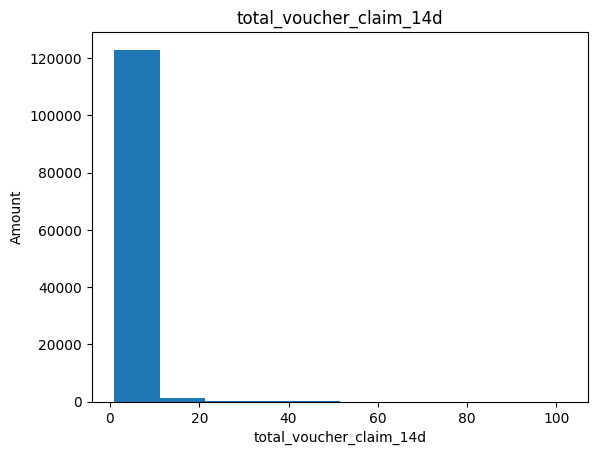

Column Name: total_order_14d
Values: [ nan   4.   1.   3.   2.   8.  14.   5.   6.   9.   7.  12.  15.  11.
  10.  13.  34.  16.  20.  17.  22.  24.  30.  27.  31.  32.  19.  25.
  29.  18.  41.  21.  40.  23.  33.  35.  65.  47.  78.  28.  67.  26.
  39.  43.  45.  77.  42.  61.  38.  37.  36.  85.  46.  53.  60.  62.
  86.  51.  74.  55.  69.  54.  82.  58.  49.  56.  48.  81.  44.  63.
  50.  68.  89.  79. 102. 107.  80.  71.  52.  66.  75.  57.  88. 122.
  59.  98. 112. 100.  64.  84.  70.  90. 104. 118. 340. 181. 141. 125.
 146. 352. 106. 280.  76. 568. 101.  83.  72.  87.]


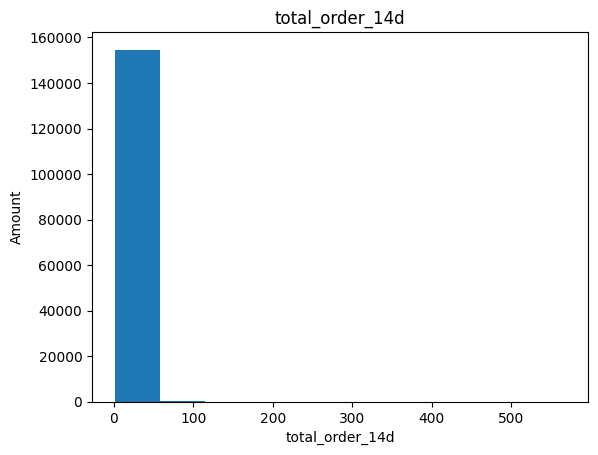

Column Name: gmv_14d
Values: [     nan  351050.   47500. ...  122847. 7925682.  539300.]


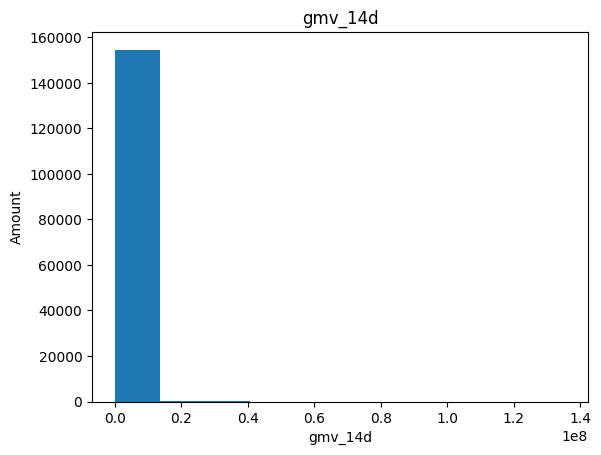

Column Name: pdp_views_14d
Values: [  36.    4.   77. ... 1936. 1964. 1780.]


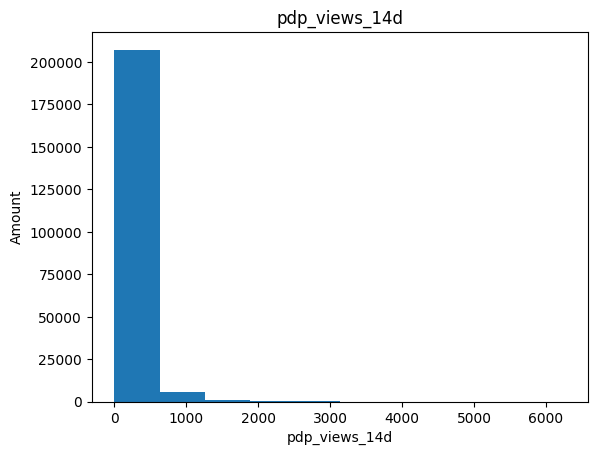

Column Name: shop_views_14d
Values: [      nan 9.000e+00 4.200e+01 2.500e+01 5.000e+00 1.000e+00 1.600e+01
 2.000e+00 7.000e+00 3.000e+00 5.310e+02 1.450e+02 8.000e+00 3.300e+01
 5.400e+01 1.900e+01 1.210e+02 1.400e+01 2.600e+01 1.740e+02 1.110e+02
 1.200e+01 6.000e+00 1.100e+01 7.600e+01 1.500e+01 4.000e+00 2.100e+01
 1.470e+02 1.700e+01 1.300e+01 1.000e+01 3.100e+01 4.100e+01 1.800e+01
 1.100e+02 2.000e+01 3.200e+01 4.400e+01 1.130e+02 2.700e+01 6.500e+01
 1.940e+02 3.700e+01 2.400e+01 4.600e+01 3.600e+01 5.300e+01 8.800e+01
 7.000e+01 6.400e+01 4.300e+01 5.600e+01 3.500e+01 4.500e+01 3.400e+01
 2.300e+01 2.800e+01 9.300e+01 9.600e+01 8.600e+01 2.200e+01 9.700e+01
 5.700e+01 1.530e+02 9.200e+01 8.900e+01 1.890e+02 3.000e+01 8.300e+01
 4.800e+01 1.270e+02 4.900e+01 6.600e+01 1.580e+02 2.310e+02 3.800e+01
 1.040e+02 5.100e+01 7.300e+01 1.990e+02 5.800e+01 1.250e+02 7.700e+01
 2.900e+01 7.800e+01 1.300e+02 6.900e+01 7.500e+01 1.050e+02 1.240e+02
 4.000e+01 5.900e+01 5.500e+01 6.800e+01 

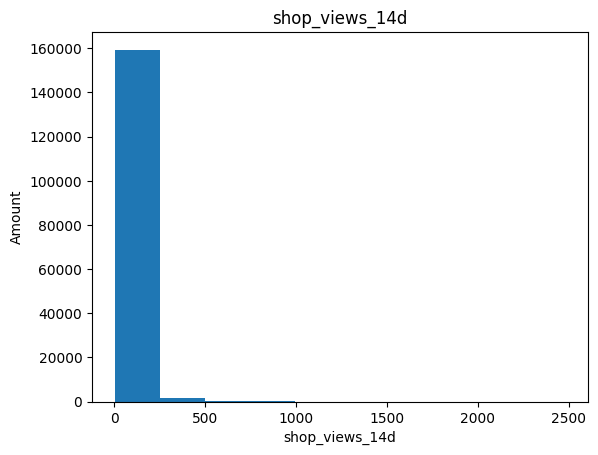

Column Name: total_login_sessions_l14d
Values: [  5.   4.   3.   1.  28. 107.  34.  18.   7.  24.  10.  19.  44.  74.
   8.  60.  91.  32.  51.  13.  20.  52. 109.  59. 101.  33.   6.  11.
   9.   2.  68.  12.  36.  25.  46.  23.  35.  16.  15.  26.  22.  66.
  27.  48. 163.  21.  39.  72.  75.  77.  38.  17.  96.  14.  nan  99.
  40.  70. 296.  58. 118.  29.  56.  43.  57. 172.  45.  47.  73.  64.
  53.  84. 121.  67. 103.  41. 152.  37.  97.  82. 140.  42.  49. 161.
  30. 165.  92. 114.  55. 115.  31.  63.  89.  71.  88.  50.  79.  93.
  54.  87. 120.  61. 102.   0. 153.  76. 192.  78.  62.  81. 144.  65.
  95.  98. 136. 105. 125.  85.  94. 190.  83. 164. 176. 123. 282. 127.
 104. 193. 119.  86.  90. 170. 141. 169. 129. 158.  69. 196. 111. 198.
  80. 113. 257. 122. 228. 202. 106. 139. 147. 142. 134. 126. 227. 167.
 241. 148. 124. 151. 112. 266. 154. 100. 138. 130. 162. 135. 108. 143.
 149. 156. 157. 178. 175. 133. 110. 275. 321. 455. 166. 263. 191. 182.
 334. 226. 197. 230. 199. 180.

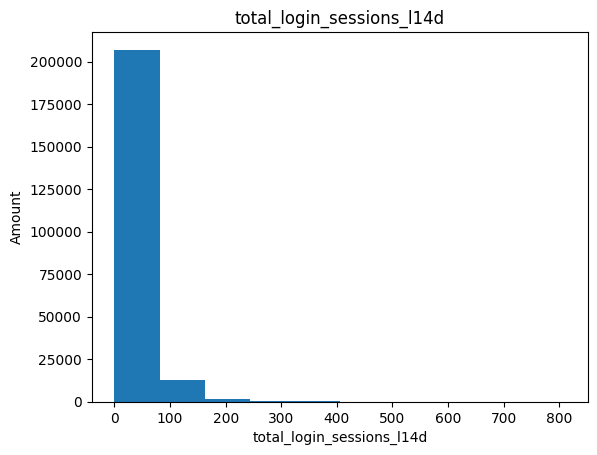

Column Name: time_spent_platform_14d
Values: [ 1325.322  2633.4    3305.075 ...  1596.482  1737.39  22060.856]


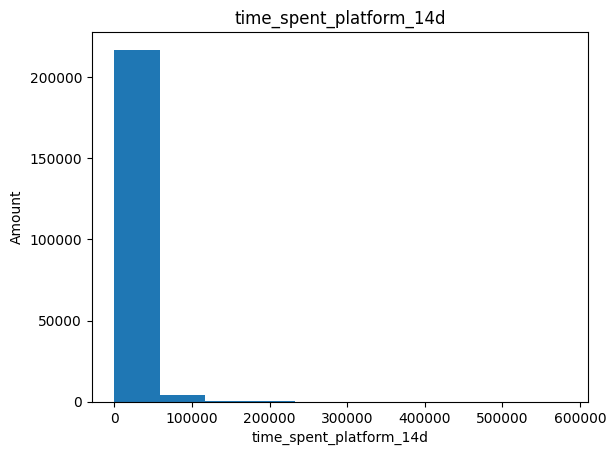

Column Name: avg_time_per_session_14d
Values: [ 265.0644      658.35       1101.69166667 ...  399.1205      115.826
  334.25539394]


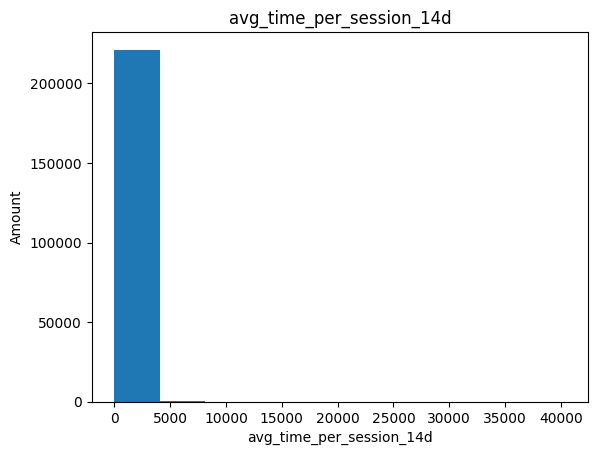

Column Name: use_shopeepay
Values: [ nan   0.   1.   2.   3.   4.   5.   6.  10.   8.   9.  20.  12.   7.
  15.  11.  14.  17.  19.  25.  37.  33.  18.  24.  34.  16.  13.  28.
  29.  21.  30.  27.  22.  42.  39.  67.  31.  23.  36.  26.  35.  63.
  47. 137.  38. 568.  41.  51.]


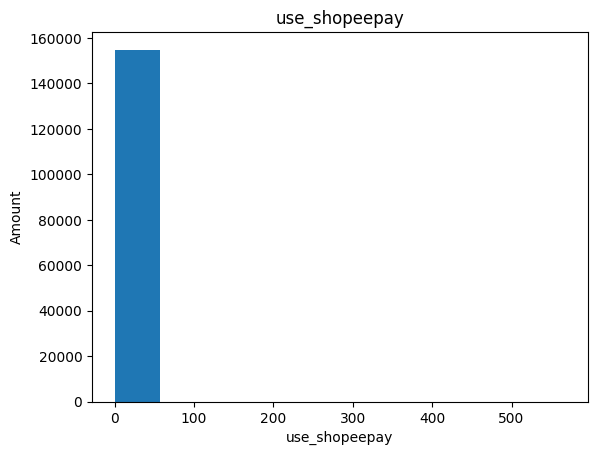

Column Name: use_shopeepaylater
Values: [nan  0.]


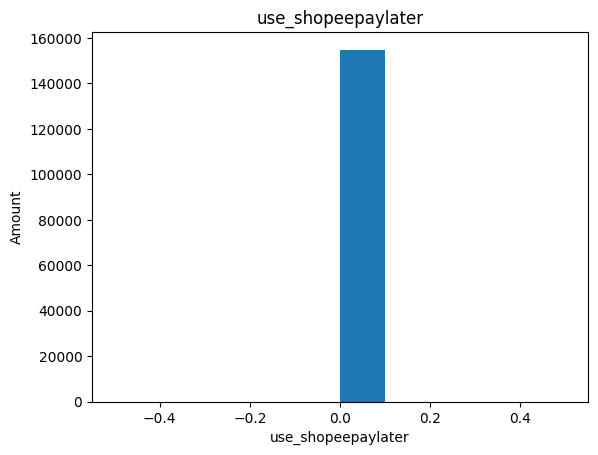

Column Name: use_cod
Values: [ nan   4.   0.   3.   2.   1.   5.   6.   7.   8.  12.   9.  13.  10.
  11.  14.  19.  17.  16.  21.  20.  15.  22.  18.  30.  27.  26.  35.
  38.  32.  53.  41.  29.  24.  23.  60.  49.  34.  28.  25.  31.  36.
  37.  50.  52.  86.  51.  56.  54.  40.  66.  39.  88.  65.  62.  42.
  63.  47.  59.  43.  33.  44. 100.  64.  57.  70.  90.  75. 104.  46.
  48.  55.  45.  61.  79.  72.  80.  73.  67.]


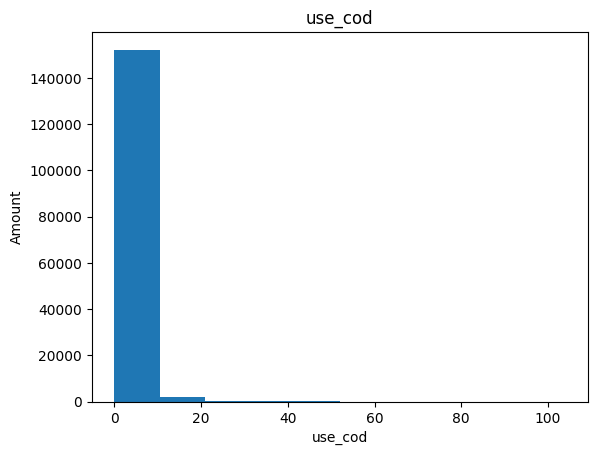

Column Name: use_va_bt
Values: [ nan   0.   1.   2.   3.   4.   7.   6.   5.   8.  18.   9.  24.  11.
  17.  20.  10.  12.  13.  15.  37.  14.  19.  27.  16.  21. 258.  23.
  83.  43.  50.  25.]


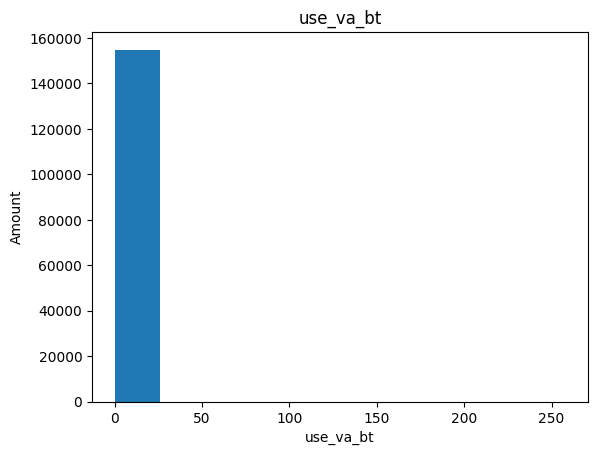

Column Name: use_cc_debit
Values: [nan  0.  1.  3.  2.  7.  4.  9.  6. 10.  8.  5.]


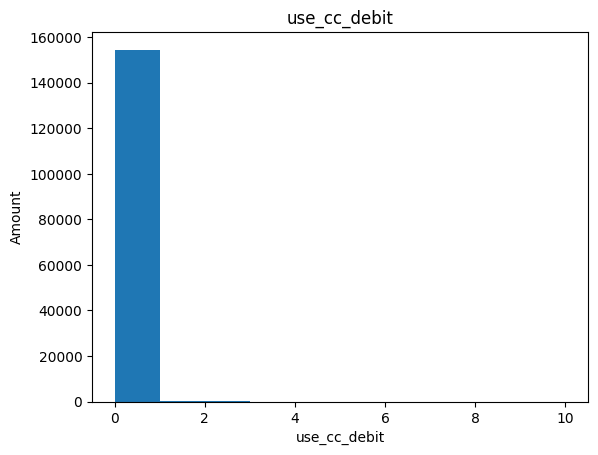

Column Name: use_instant
Values: [nan  0.  1.  2.  7.  3.  4.  5. 21. 18.]


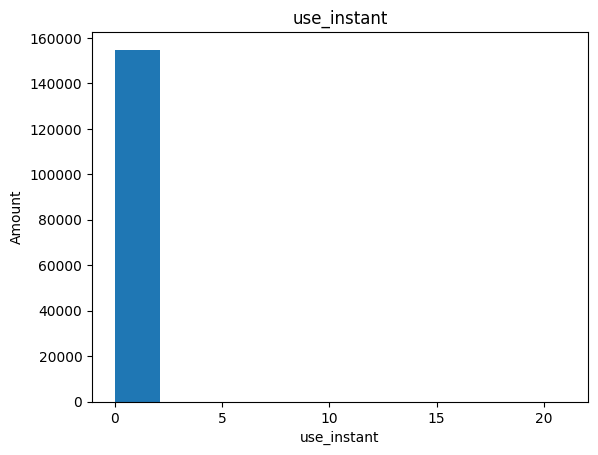

Column Name: use_sameday
Values: [nan  0.  1.  2.  4.  3. 13.  5. 10.  7.  9.]


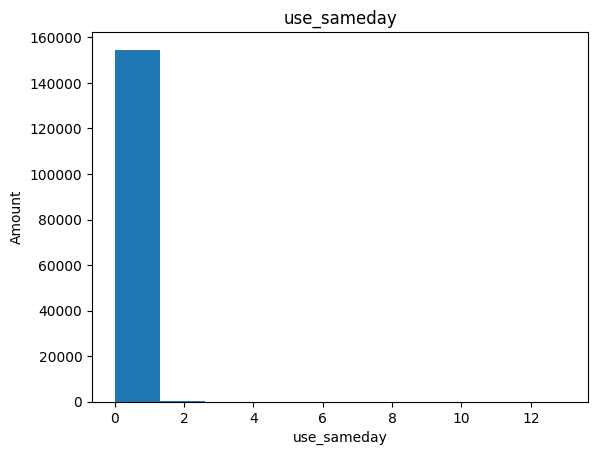

Column Name: use_nextday
Values: [nan  0.  1.  2.  3.  5. 34.]


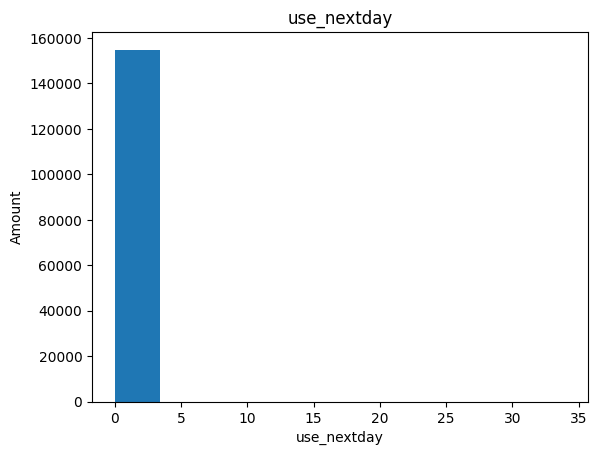

Column Name: use_regular
Values: [ nan   4.   1.   3.   2.   0.   5.   6.   8.   7.  15.  13.   9.  10.
  12.  11.  28.  14.  19.  18.  21.  16.  25.  32.  17.  20.  24.  30.
  27.  26.  35.  48.  29.  23.  39.  36.  53.  41.  31.  34.  22.  38.
  33.  63.  49.  40.  37.  50.  52.  86.  47.  60.  51.  56.  57.  43.
  66.  88.  64.  62.  42.  65.  59.  44. 100.  70.  90.  75. 104.  46.
  55. 230.  58.  45.  54.  61.  79.  72.  80.  67.]


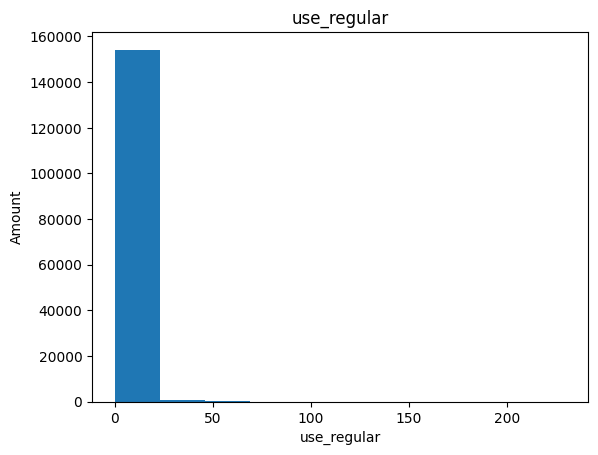

Column Name: use_hemat
Values: [nan  0.  1.  3.  4.  2.  7.  5.  8.  6.  9. 10. 21. 11. 18. 15. 24. 12.
 17. 13. 29. 14. 30. 23. 45.]


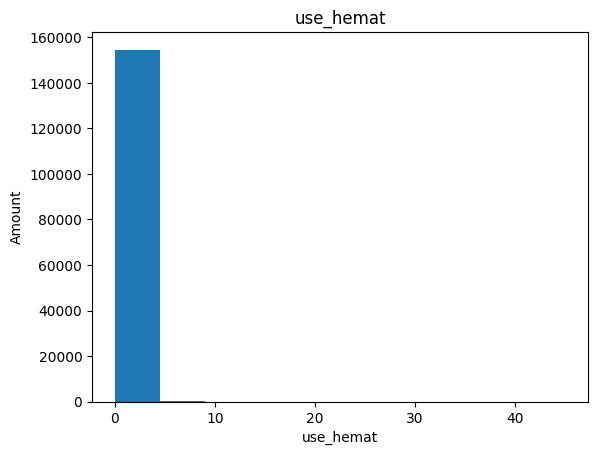

Column Name: shop_mall
Values: [nan  0.  1.  2.  3.  4.  7.  5.  8.  6. 14.  9. 13. 12. 10. 15. 25. 31.
 23. 11. 16. 40. 21. 18. 32.]


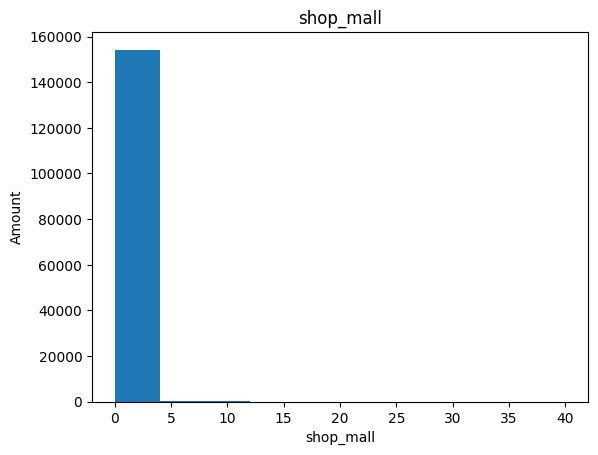

Column Name: shop_ss_plus
Values: [ nan   2.   1.   0.   4.   5.   3.   8.  11.   6.   7.   9.  23.  10.
  12.  13.  22.  14.  15.  18.  17.  16.  24.  33.  21.  29.  27.  25.
  30.  20.  19.  36.  37.  35.  26.  31.  49.  32.  28.  34.  76.  41.
  67.  57.  38.  61.  62.  39.  47.  70.  60.  52.  63. 235.  42. 115.
  74.  46.  50.  77.  55.  69.  48.  43.  65.  53.]


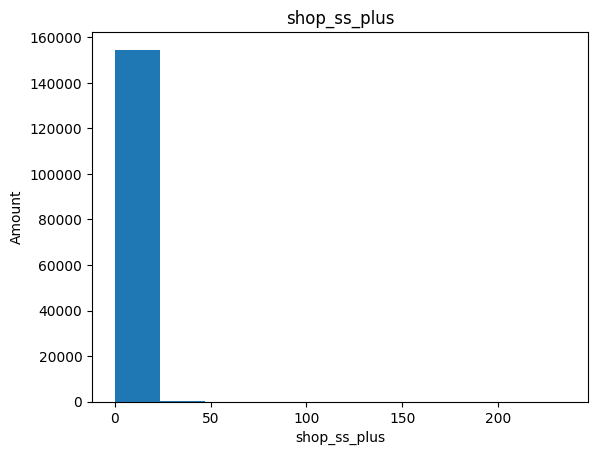

Column Name: shop_ss
Values: [ nan   2.   1.   0.   4.   5.   3.   8.  11.   6.   7.   9.  23.  10.
  12.  13.  22.  14.  15.  18.  17.  16.  24.  33.  21.  29.  27.  25.
  30.  20.  19.  36.  37.  35.  26.  31.  49.  32.  28.  34.  76.  41.
  67.  57.  38.  61.  62.  39.  47.  70.  60.  52.  63. 235.  42. 115.
  74.  46.  50.  77.  55.  69.  48.  43.  65.  53.]


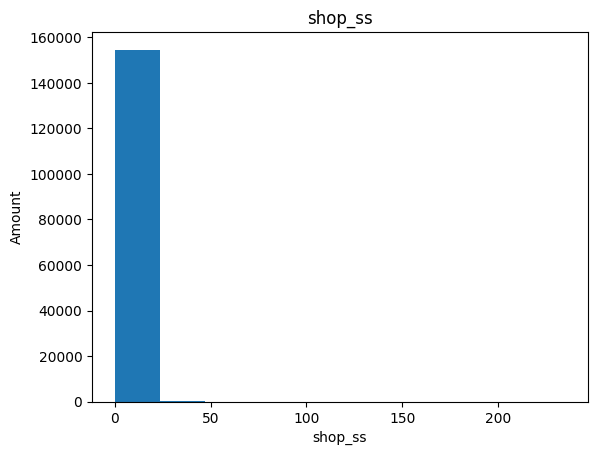

Column Name: shop_cb
Values: [nan  0.  1.  2.  3.  4.  5.  6.  7.  9. 12. 11. 16. 18. 14. 15.]


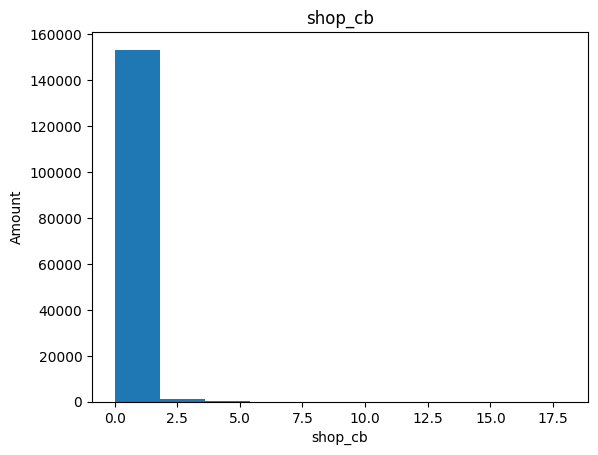

Column Name: shop_sbs
Values: [nan  0.  1.  2.  3.  4. 13.]


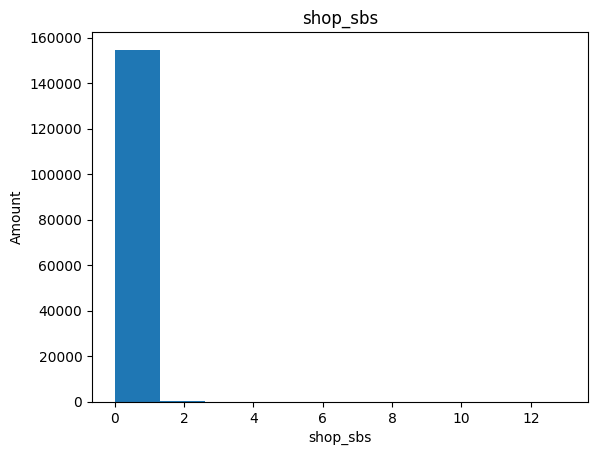

Column Name: shop_normal_shop
Values: [ nan   2.   0.   1.   3.   9.   4.   5.   7.   6.   8.  11.  10.  12.
  13.  17.  21.  14.  20.  29.  23.  15.  22.  24.  37.  26.  49.  34.
  19.  16.  18.  63.  33.  25.  72.  38.  39.  27.  30.  45.  35.  28.
  31.  50.  41.  53.  36.  54.  43.  32.  67.  86.  60.  51.  56.  42.
  52.  40.  66.  88.  62.  57.  65.  59.  73.  44. 100.  64.  48.  90.
  75. 105.  55. 329. 198. 544.  61.  83.  79.  46.  80.  47.  58.]


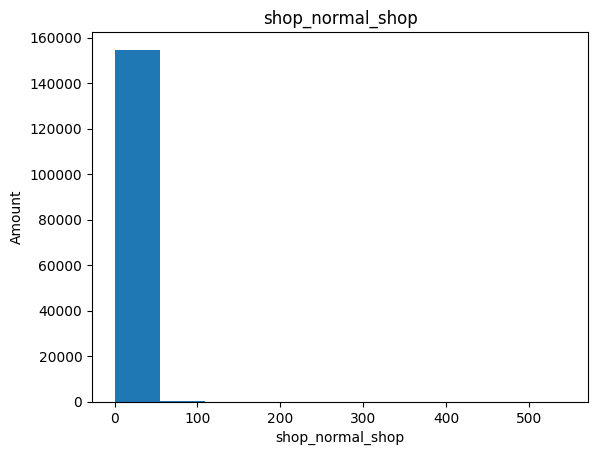

Column Name: shop_flash_sale
Values: [nan  0.  1.  2.  3.  4.  9.  8.  7.  5.  6. 12. 11.]


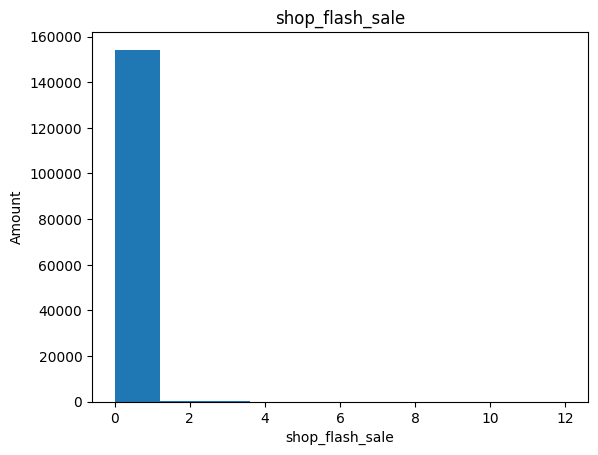

Column Name: top_up_14d
Values: [     nan   90000.   50000. ...  101600.  418678. 2415054.]


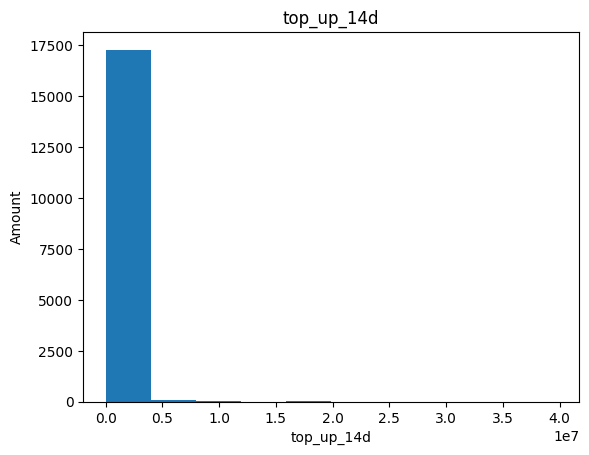

In [ ]:
# Check missing value for numerical
df = df_ori.copy()
missing_numerical_columns = [
    "total_voucher_claim_14d",
    "total_order_14d",
    "gmv_14d",
    "pdp_views_14d",
    "shop_views_14d",
    "total_login_sessions_l14d",
    "time_spent_platform_14d",
    "avg_time_per_session_14d",
    "use_shopeepay",
    "use_shopeepaylater",
    "use_cod",
    "use_va_bt",
    "use_cc_debit",
    "use_instant",
    "use_sameday",
    "use_nextday",
    "use_regular",
    "use_hemat",
    "shop_mall",
    "shop_ss_plus",
    "shop_ss",
    "shop_cb",
    "shop_sbs",
    "shop_normal_shop",
    "shop_flash_sale",
    "top_up_14d",
]
for col in missing_numerical_columns:
    print(f"Column Name: {col}")
    print(f"Values: {df[col].unique()}")
    plt.hist(df[col])
    plt.title(col)
    plt.xlabel(f"{col}")
    plt.ylabel("Amount")
    plt.show()

In these columns one conclusion that I could take is `nan` value means that the user doens't involved in these criterias, so replacing it with `0` would have the same meaning

**Action to take**: fill missing value with `0`, which means user doesn't involved or used some of service, payment, activation, and more.

## Check Constant Values

In [ ]:
df = df_ori.copy()
for f in df.columns:
    if df[f].nunique() == 1:
        print(f"There are {df[f].nunique()} unique values inside {f} column")
        print(f"Values: {df[f].unique()}")

There are 1 unique values inside use_shopeepaylater column
Values: [nan  0.]


Column that has constant value doesn't contribute to the prediction because it couldn't provide any characteristics for the dependent or target variable.

**Action to take**: drop column that has constant value.

## Data Cleaning In Action

In [ ]:
# Data Cleaning
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    MISSING_TEXT_COLUMNS = ["new_buyer_initiative"]
    MISSING_NUMERICAL_COLUMNS = [
        "total_voucher_claim_14d",
        "total_order_14d",
        "gmv_14d",
        "pdp_views_14d",
        "shop_views_14d",
        "total_login_sessions_l14d",
        "time_spent_platform_14d",
        "avg_time_per_session_14d",
        "use_shopeepay",
        "use_cod",
        "use_va_bt",
        "use_cc_debit",
        "use_instant",
        "use_sameday",
        "use_nextday",
        "use_regular",
        "use_hemat",
        "shop_mall",
        "shop_ss_plus",
        "shop_ss",
        "shop_cb",
        "shop_sbs",
        "shop_normal_shop",
        "shop_flash_sale",
        "top_up_14d",
    ]
    # 1. Drop unimportant columns
    df = df.drop(columns=["user_id", "regist_date"])

    # 2. Drop duplicate rows
    df = df.drop_duplicates()  # drop duplicated data

    # 3. Drop columns containing constant value
    df = df.drop(columns=["use_shopeepaylater"])

    # 4. Fill Missing Values
    df[MISSING_NUMERICAL_COLUMNS] = df[MISSING_NUMERICAL_COLUMNS].fillna(0)
    df[MISSING_TEXT_COLUMNS] = df[MISSING_TEXT_COLUMNS].fillna("No Event")
    df = df.reset_index(drop=True)
    return df

Explanation on data cleaning:
1. Dropping `user_id` and `regist_date` because it didn't bring any predictive value.
2. Dropping duplicates so that there's no redundant information
3. Dropping `use_shopeepaylater` which contains only `0` and `nan`. These values doesn't bring any contribution to the prediction.
4. Filling missing values of `new_buyer_initiative` which means user interact with the application without any campaign events (personal assumption).
5. Filling missing numerical values with `0` which means user doesn't involved or used some of delivery service, payment, activation, and more.

# Exploratory Data Analysis

There's a lot of data containing 0 values which bring no value to the

## Multicollinearity

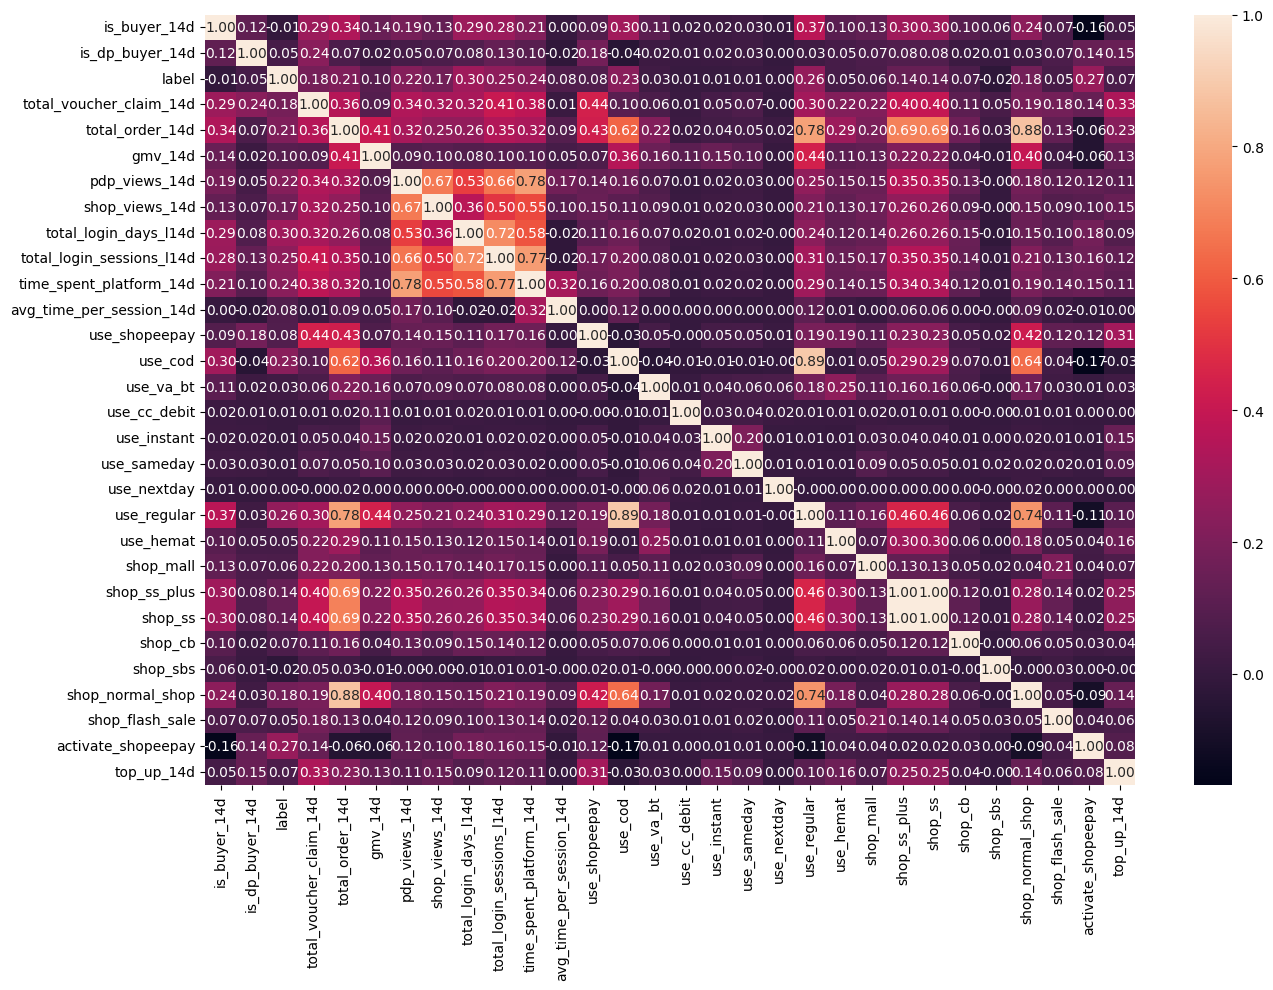

In [ ]:
df = clean_data(df_ori.copy())
plt.figure(figsize=(15, 10))
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr(), annot=True, fmt="0.2f")
plt.show()

Text(0.5, 1.0, 'Difference between Calculated `avg_time_per_session_14d` and Actual `avg_time_per_session_14d`')

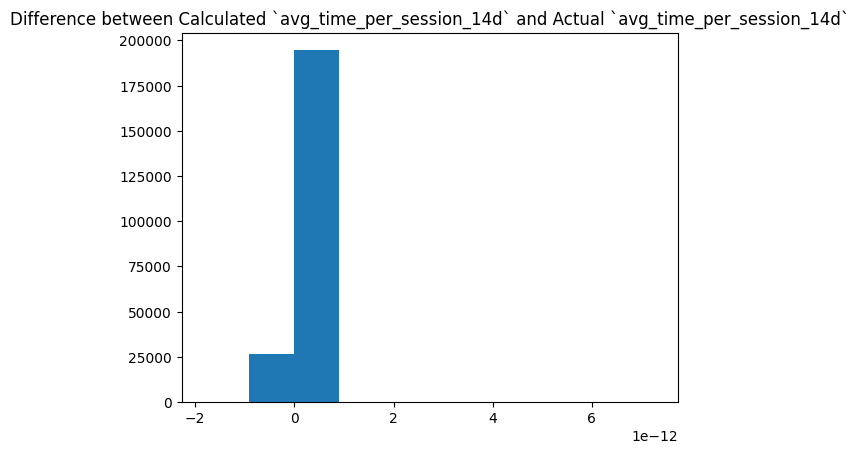

In [ ]:
# Proof of redundant features
plt.hist(df["time_spent_platform_14d"] / df["total_login_sessions_l14d"] - df["avg_time_per_session_14d"])
plt.title("Difference between Calculated `avg_time_per_session_14d` and Actual `avg_time_per_session_14d`")

<Axes: >

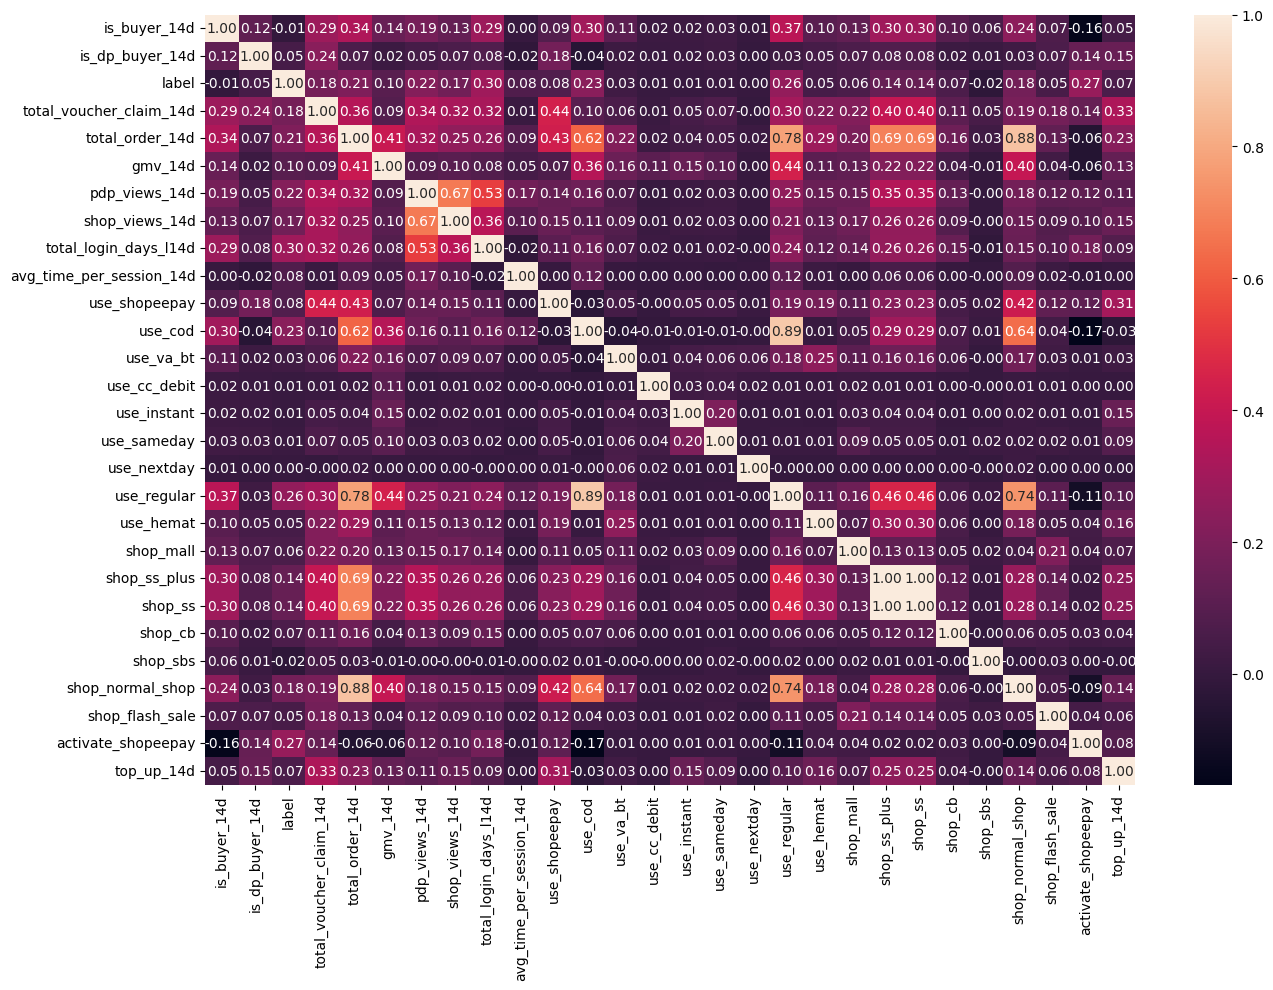

In [ ]:
df = df_ori.copy()
df = clean_data(df)
df = df.drop(columns=["time_spent_platform_14d", "total_login_sessions_l14d"])
plt.figure(figsize=(15, 10))
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr(), annot=True, fmt="0.2f")

Explanation:
1. There are some redundant features such as `total_login_sessions_l14d` and	`time_spent_platform_14d` which is summarized in `avg_time_per_session_14d` (`time_spent_platform_14d`/ `total_login_sessions_l14d`)
2. Other variables will be leaved as it is, since I didn't have the domain knowledge.

## Finding Outliers

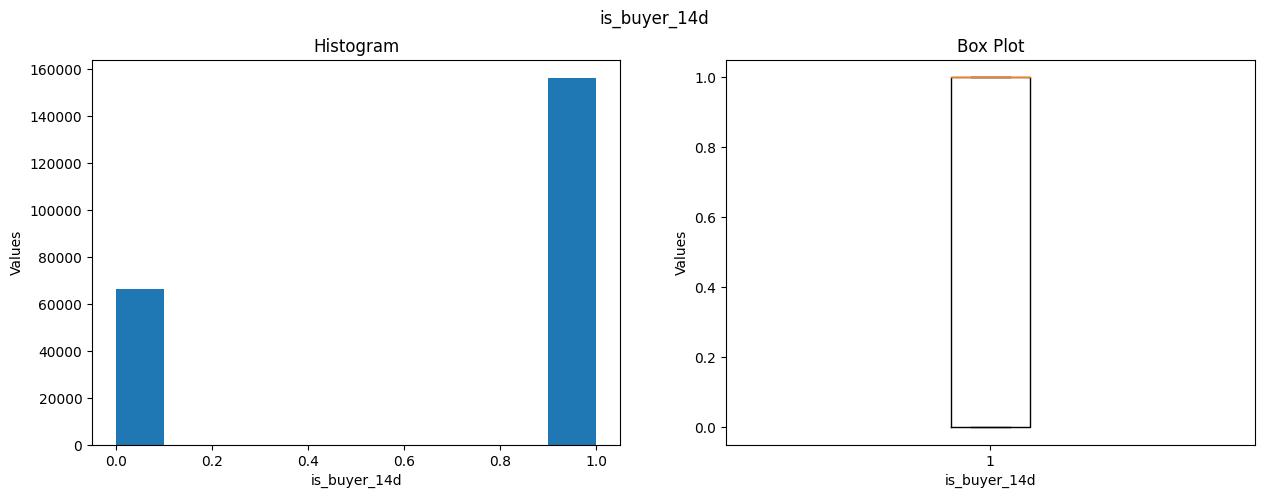

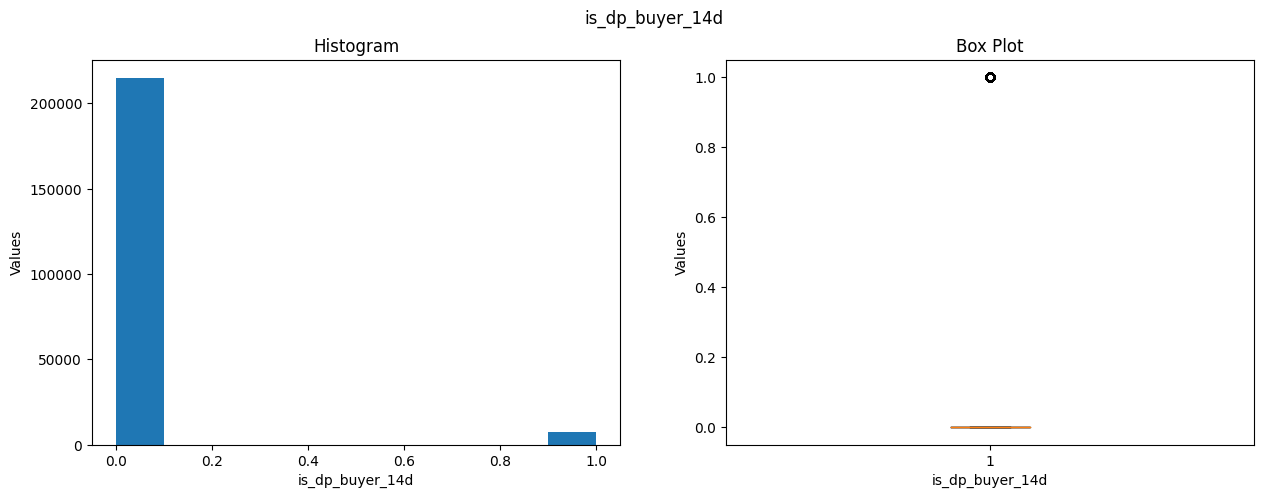

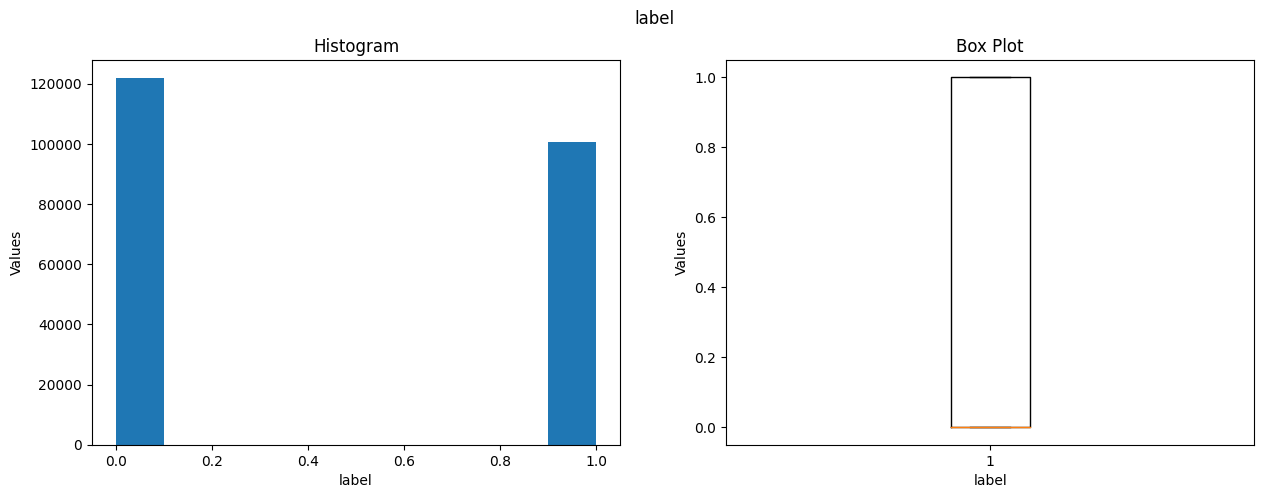

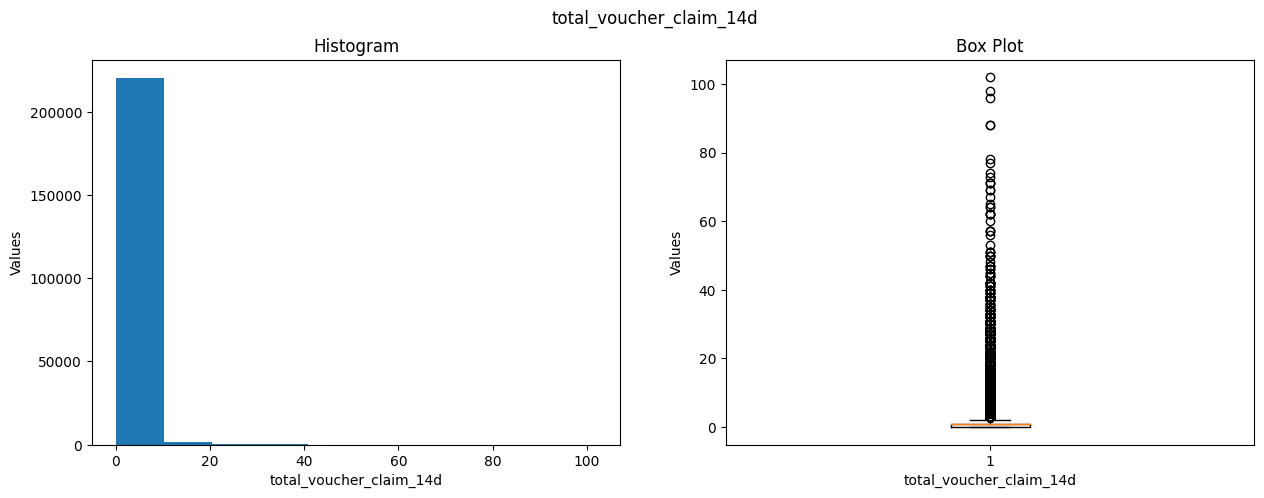

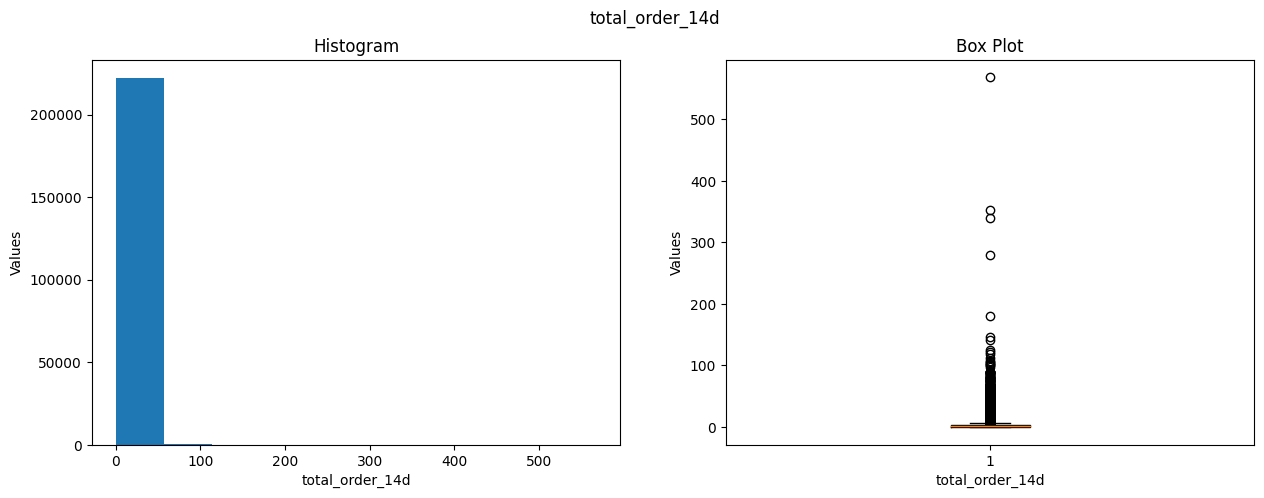

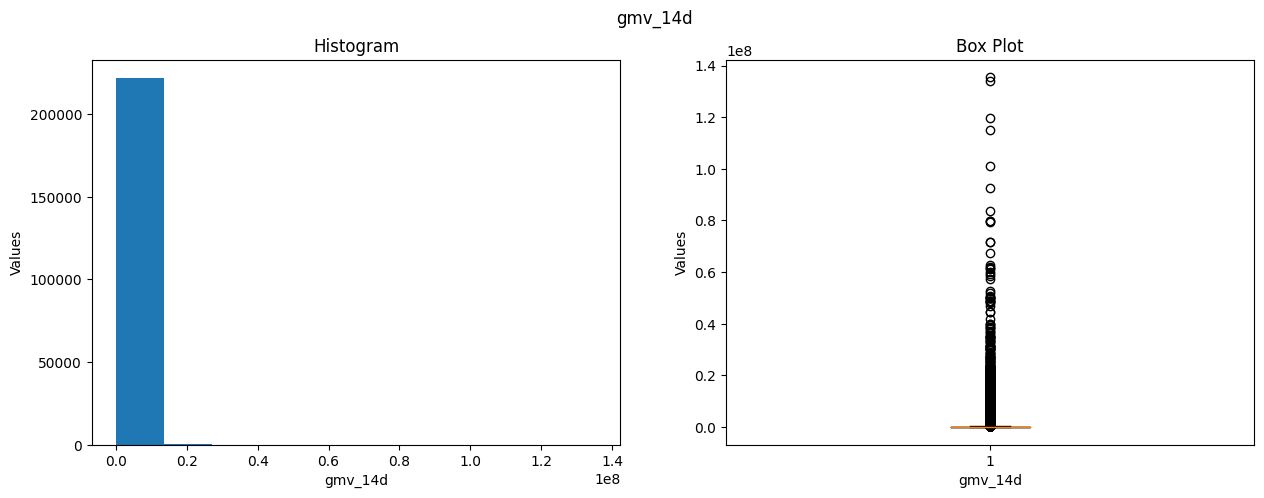

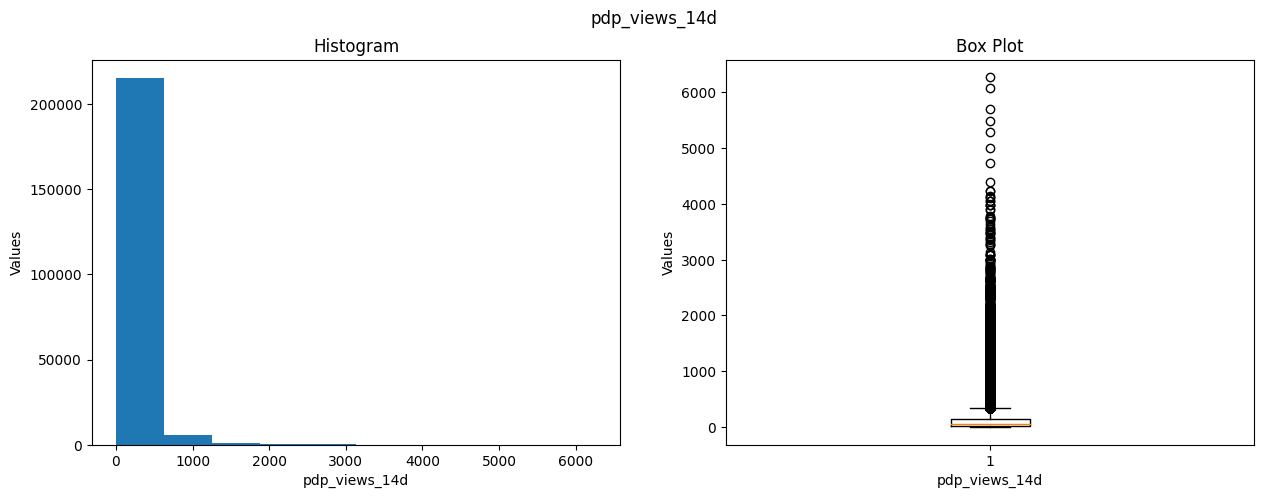

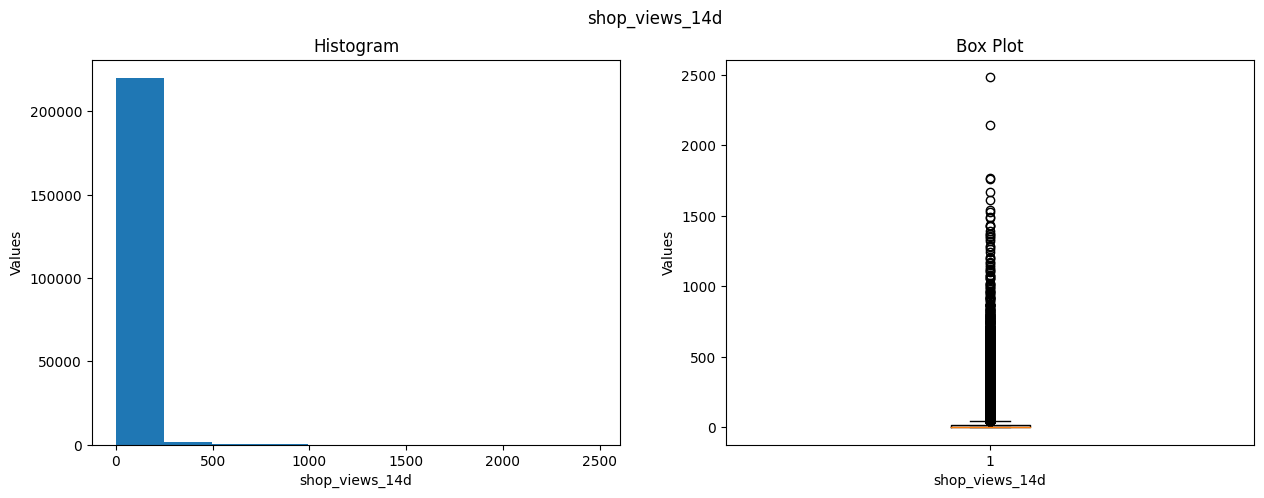

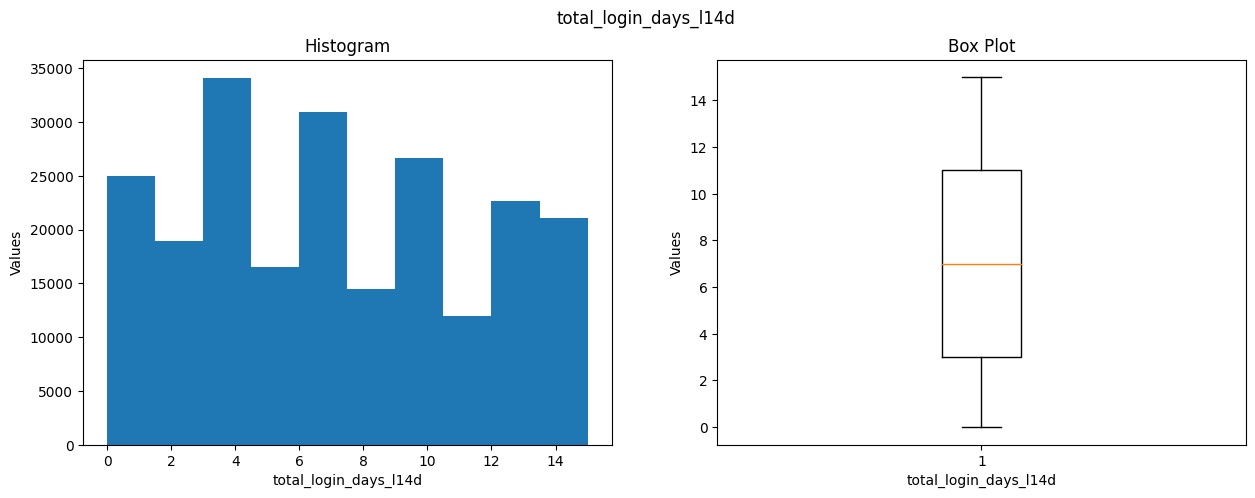

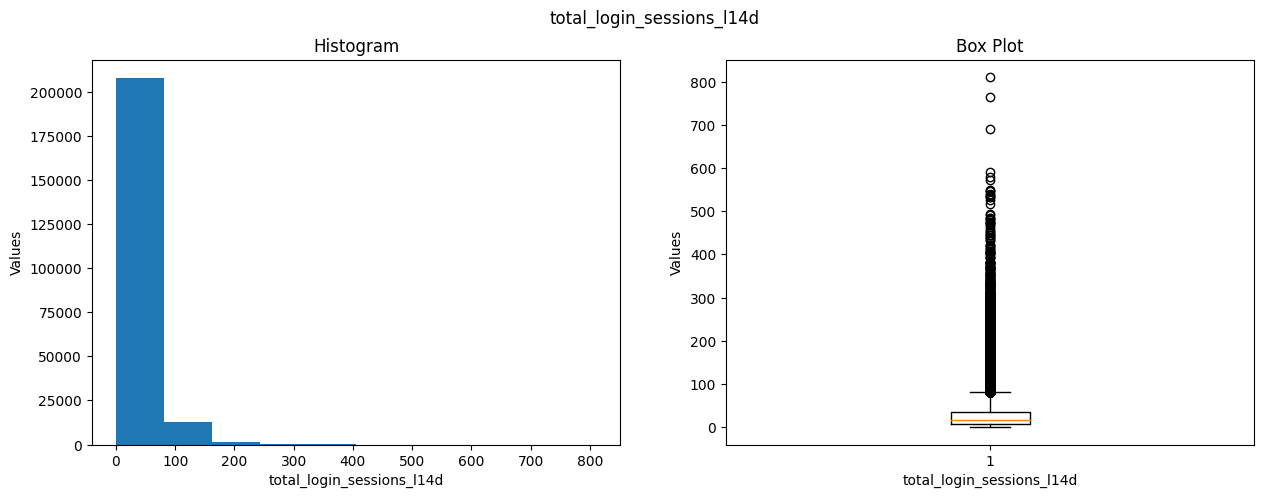

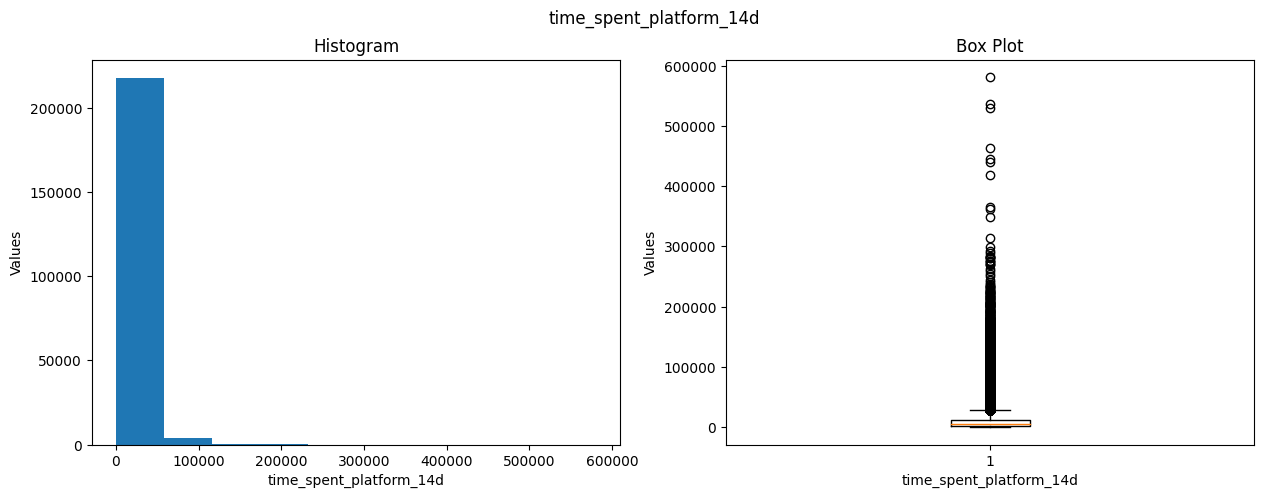

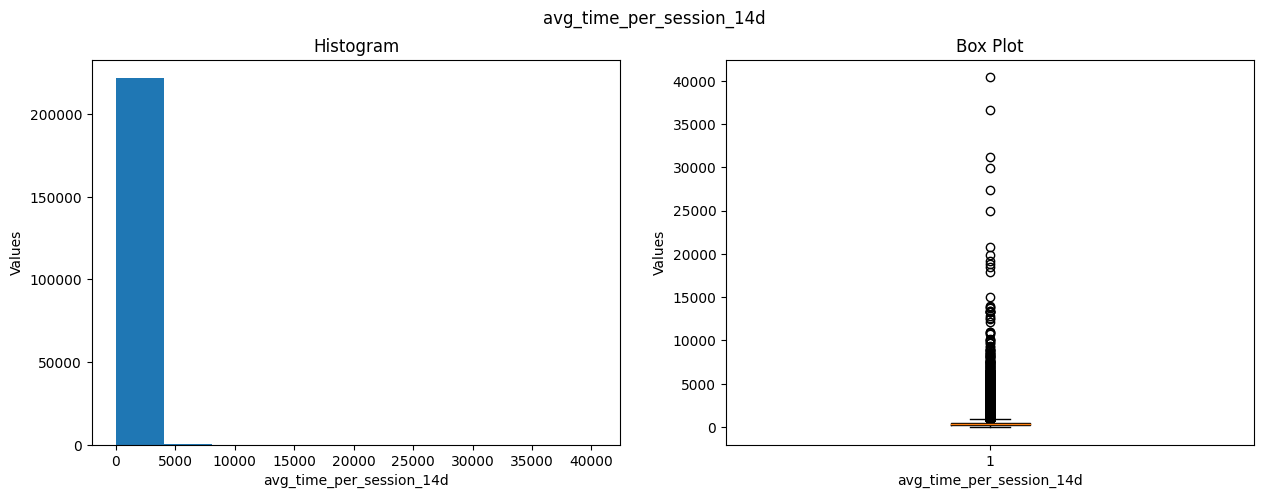

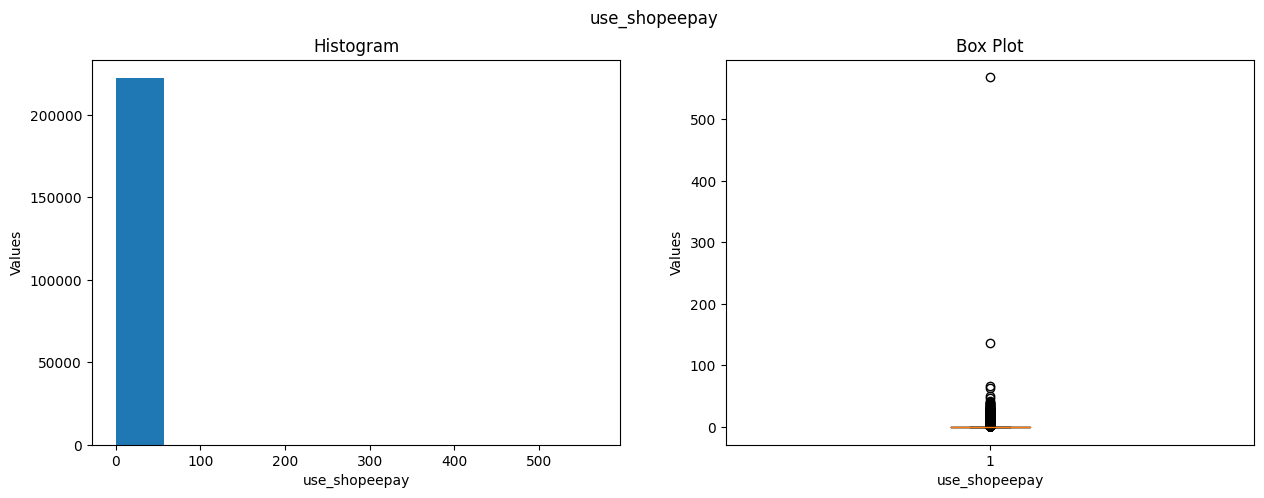

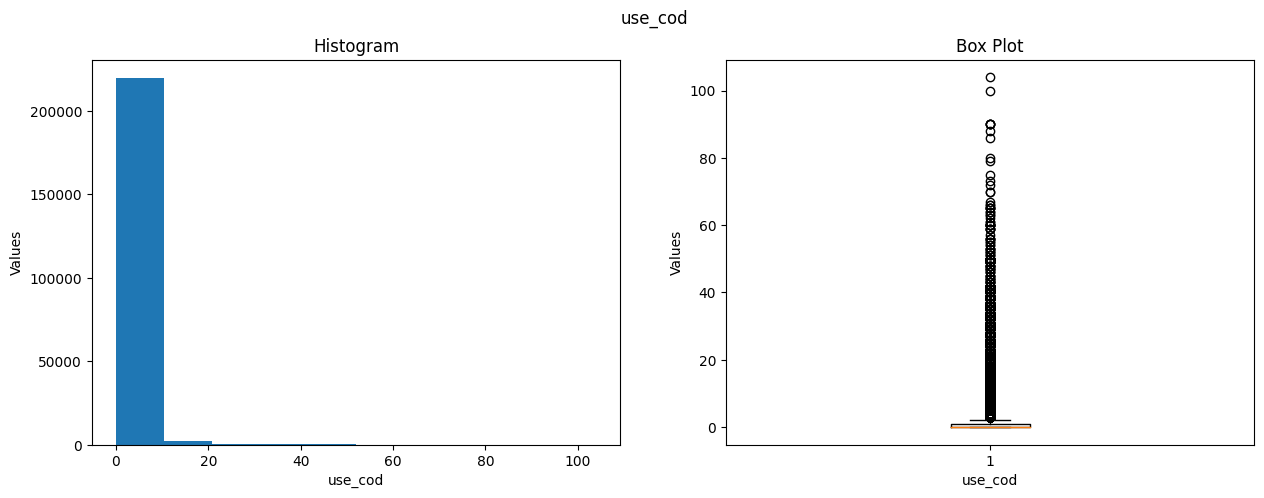

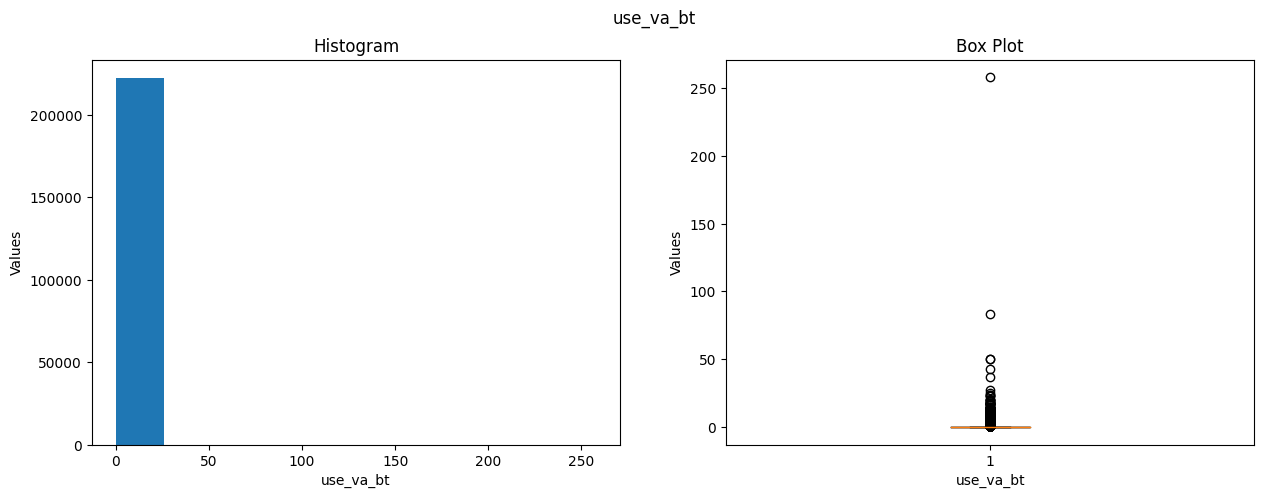

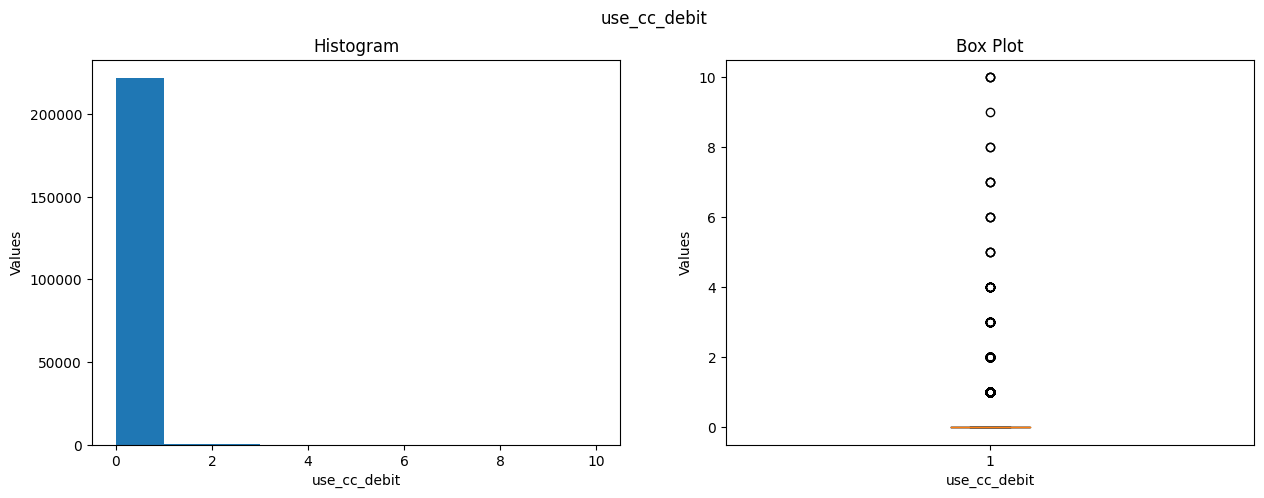

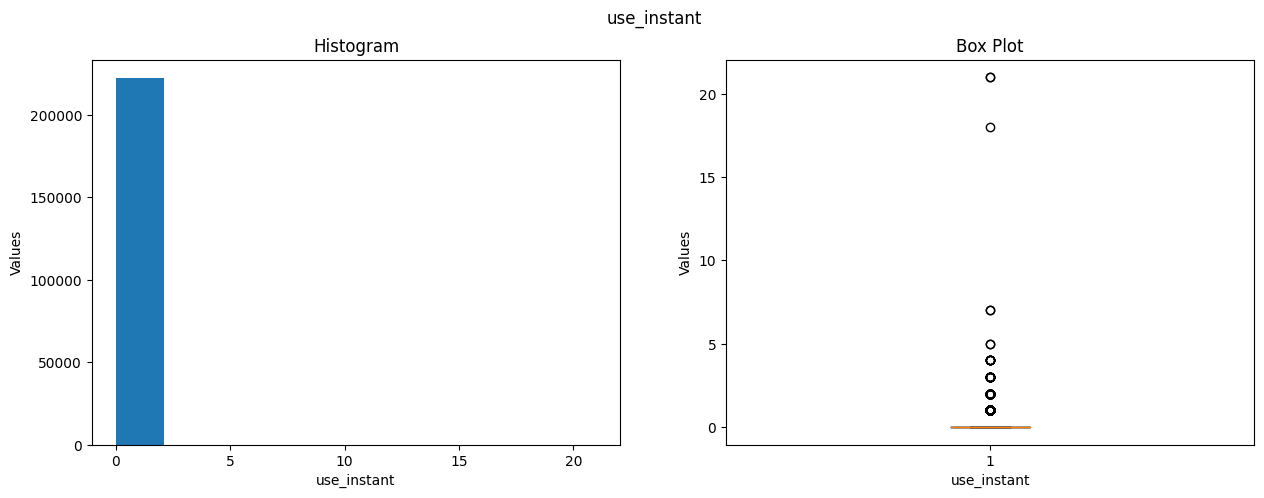

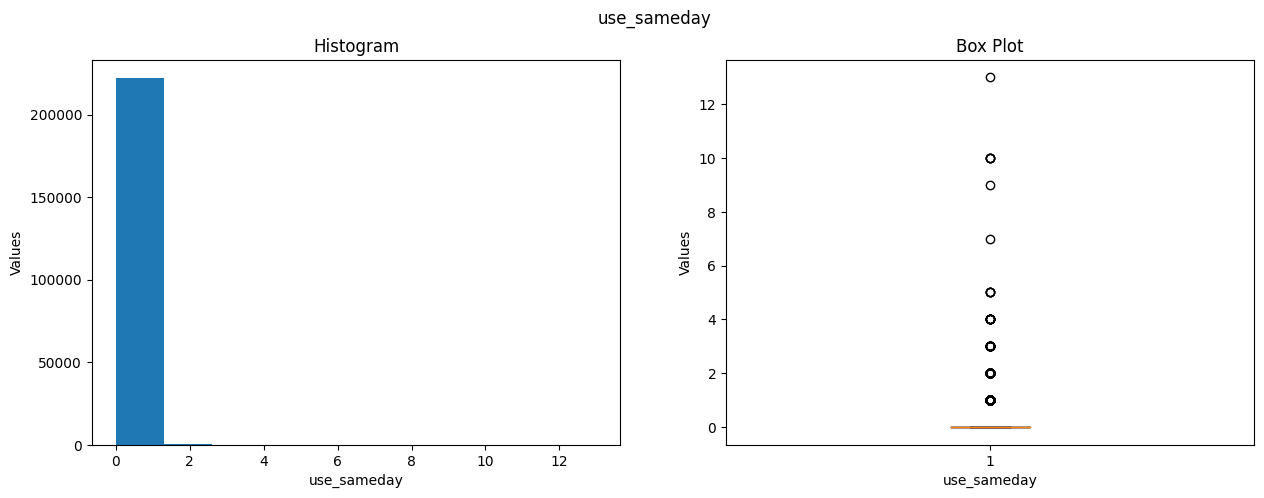

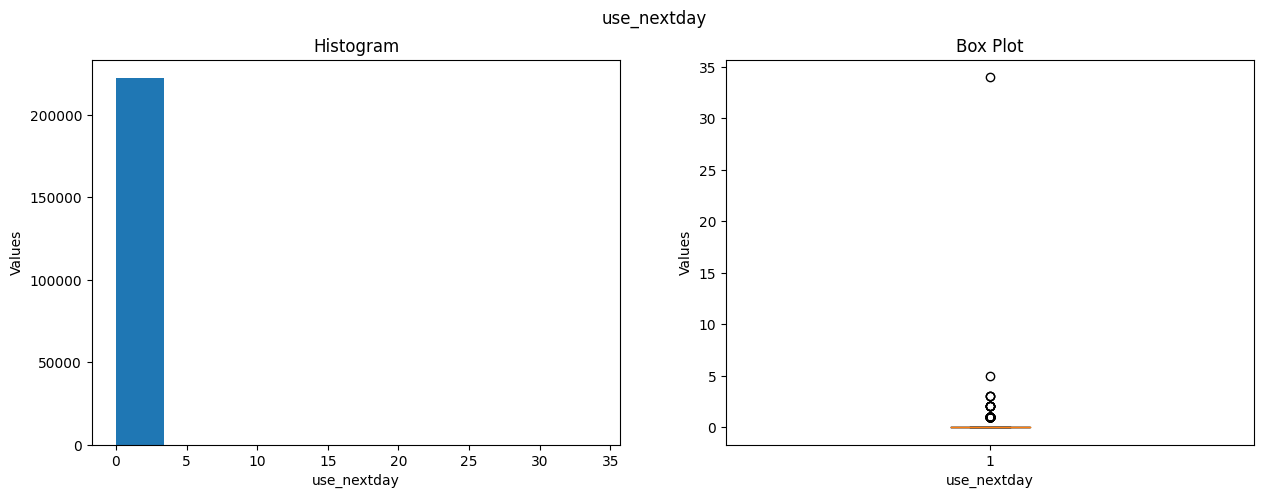

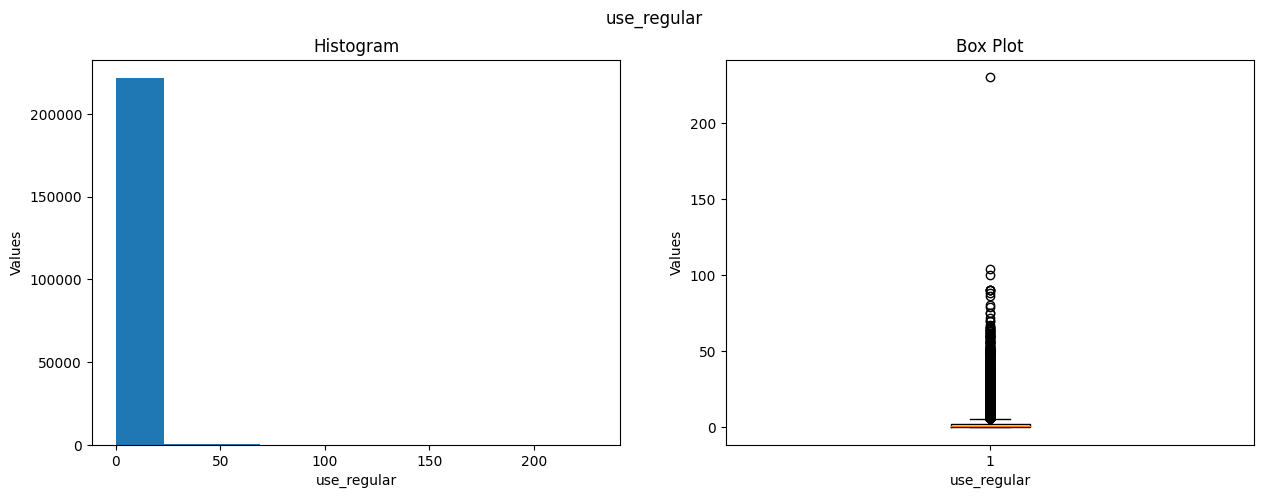

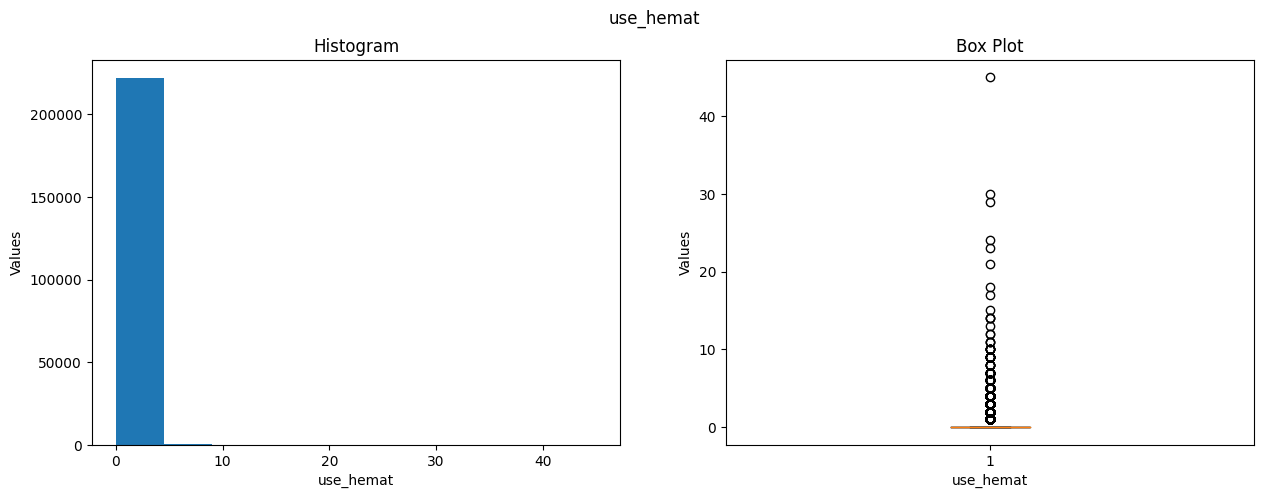

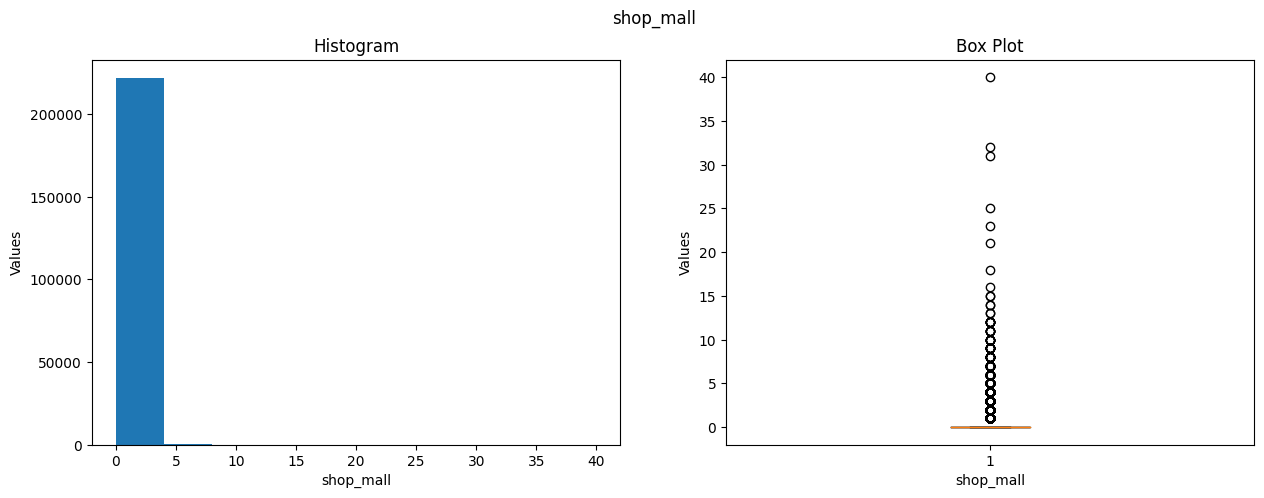

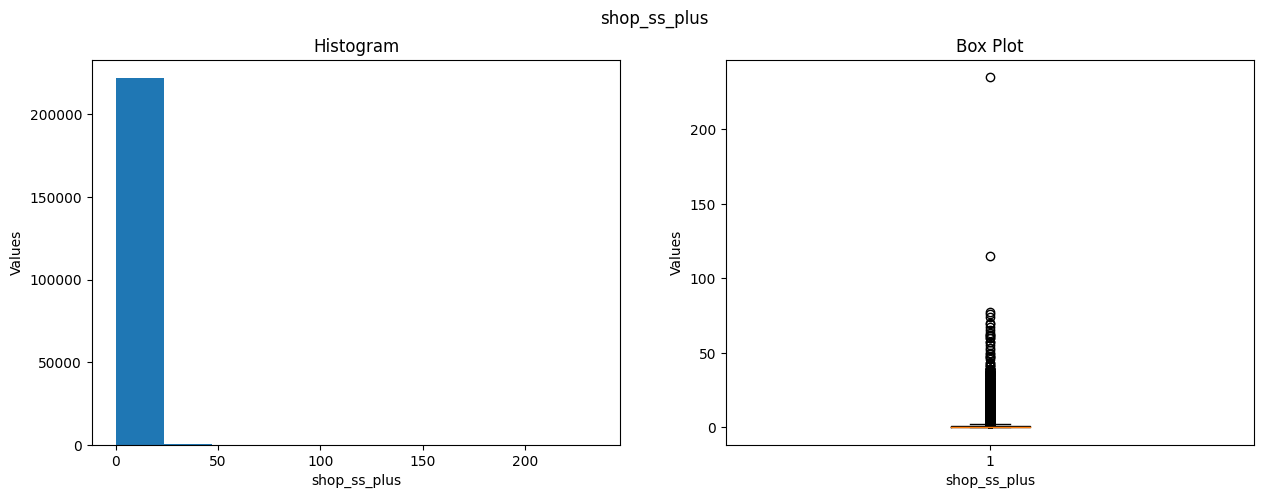

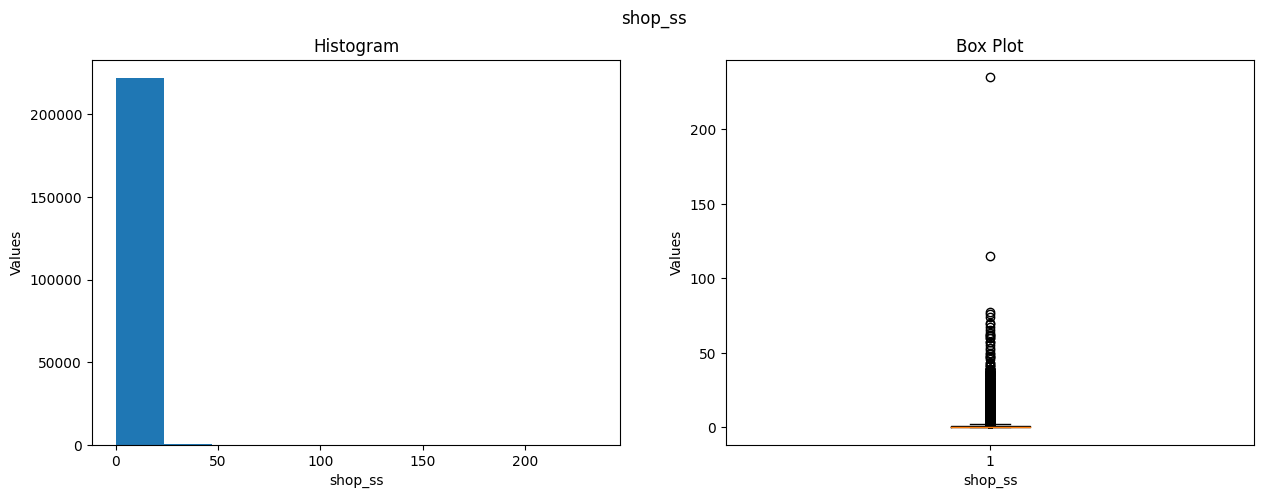

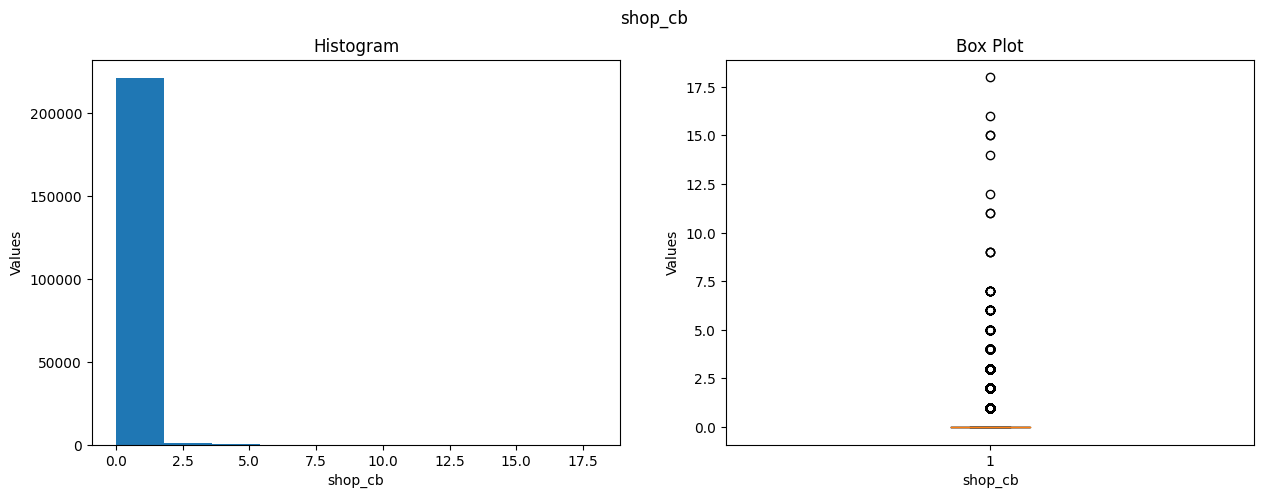

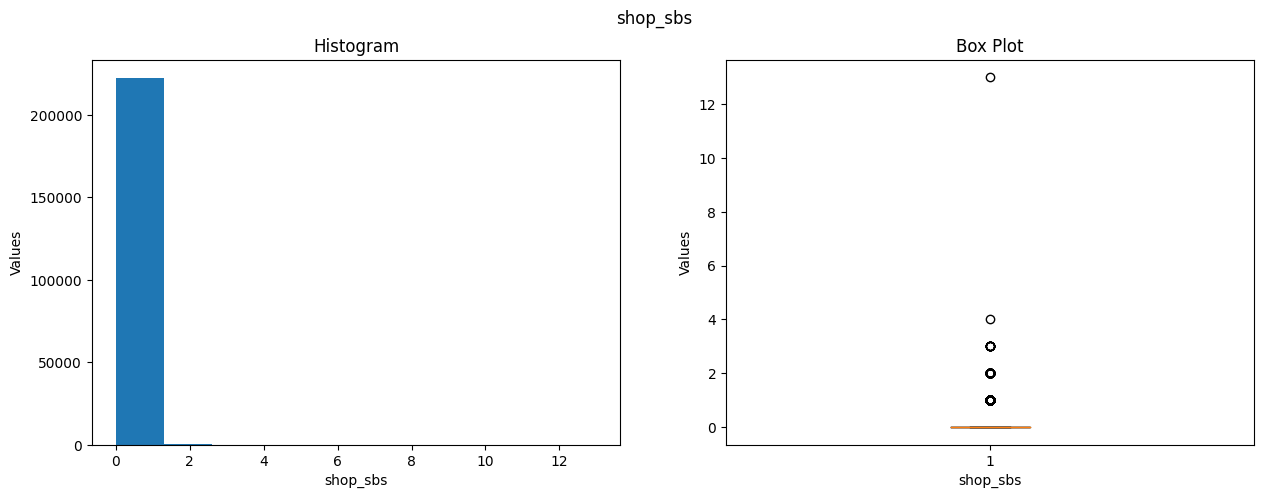

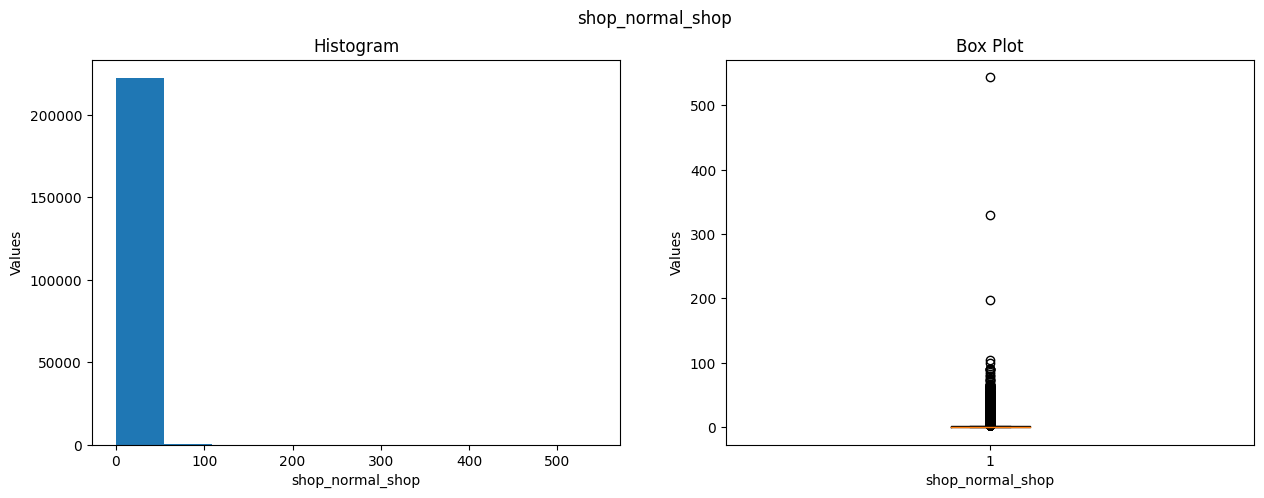

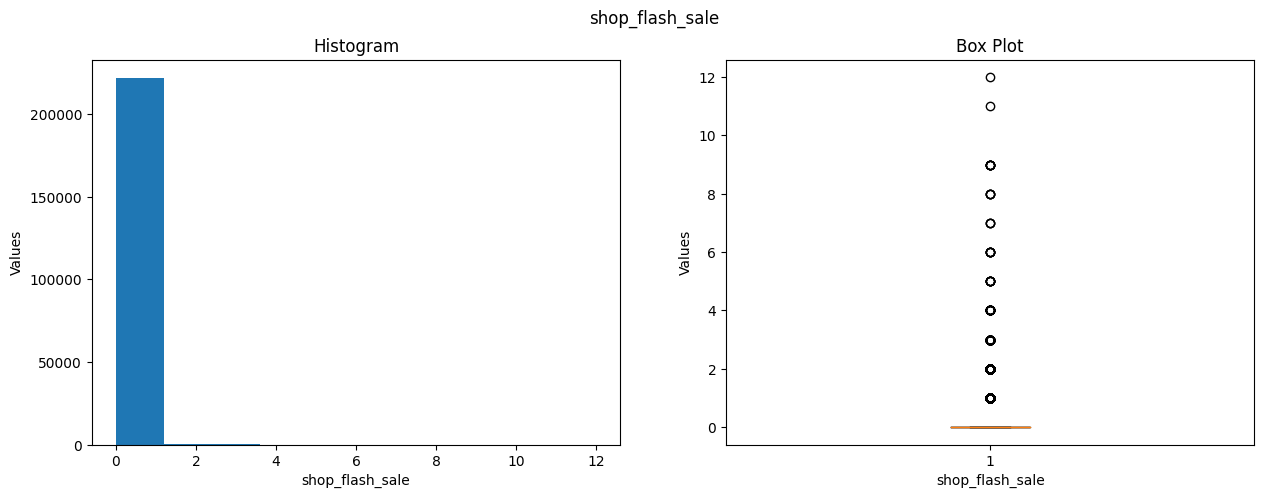

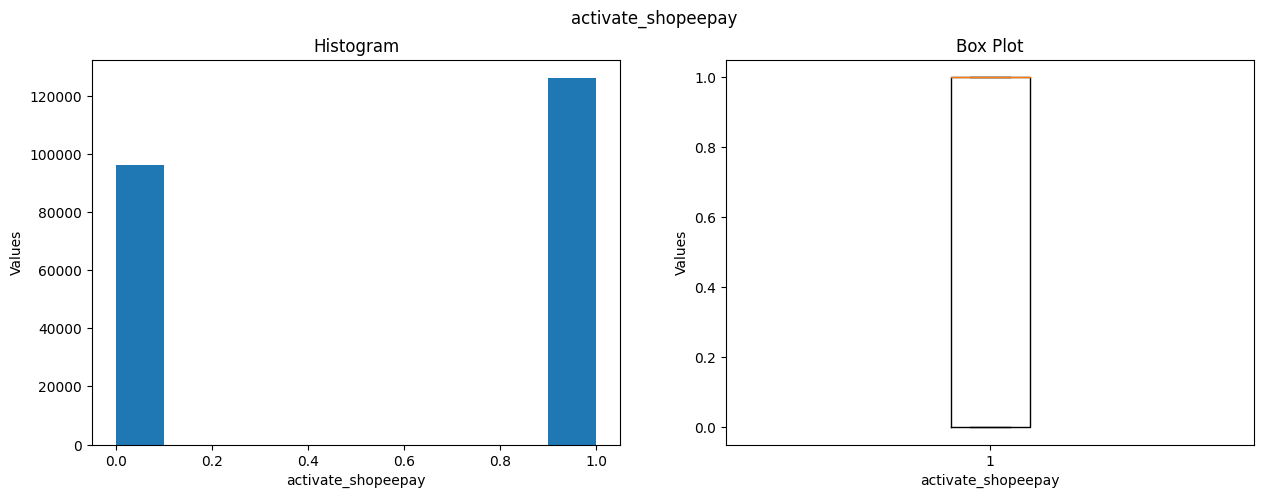

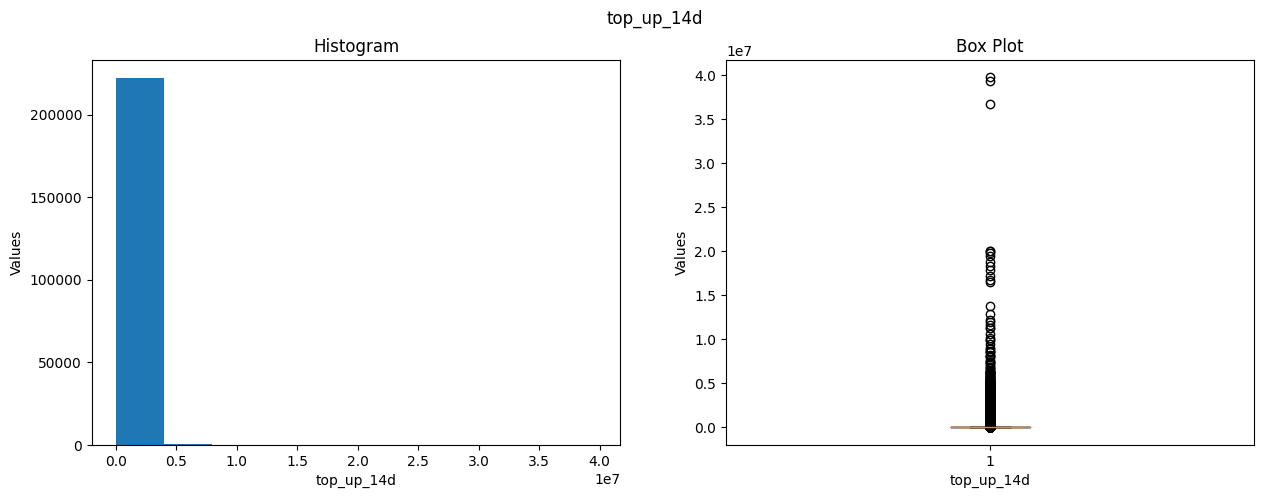

In [ ]:
df = df_ori.copy()
df = clean_data(df)
numerical_cols = df.select_dtypes(include=["int", "float"]).columns
for col in numerical_cols:
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle(col)
    ax[0].hist(df[col])
    ax[0].set_title("Histogram")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Values")

    ax[1].boxplot(df[col])
    ax[1].set_title("Box Plot")
    ax[1].set_xlabel(col)
    ax[1].set_ylabel("Values")
    plt.show()

In [ ]:
numerical_cols = df.select_dtypes(include=["int", "float"]).columns
for col in numerical_cols:
    print(f"{col}: {df[col].skew()}")

is_buyer_14d: -0.8864501226936479
is_dp_buyer_14d: 5.2275935478451006
label: 0.1934494567532888
total_voucher_claim_14d: 9.404204367980801
total_order_14d: 19.266617517513897
gmv_14d: 34.710568814366525
pdp_views_14d: 5.160305368418909
shop_views_14d: 8.61502559996718
total_login_days_l14d: 0.25527662391800077
total_login_sessions_l14d: 3.2798405566301105
time_spent_platform_14d: 5.163634197787885
avg_time_per_session_14d: 21.355977396468298
use_shopeepay: 178.37730977494135
use_cod: 6.889472238324974
use_va_bt: 131.08713619774434
use_cc_debit: 59.80184301636634
use_instant: 113.79688211993266
use_sameday: 49.65870527503566
use_nextday: 395.54463967424596
use_regular: 7.647145531433646
use_hemat: 22.054956916416433
shop_mall: 15.9932482484634
shop_ss_plus: 13.650940782576871
shop_ss: 13.650940782576871
shop_cb: 13.493618052961883
shop_sbs: 20.28001055220902
shop_normal_shop: 30.25349682583579
shop_flash_sale: 17.95853607576426
activate_shopeepay: -0.2716875343094963
top_up_14d: 56.8763

Explanation about the plot:
1. All of the columns contain outliers except: `is_buyer_14d`, `is_dp_buyer_14d`, `label`, `total_login_days_l14d`, and `activate_shopeepay`.
2. Most of outliers are positive causing the distribution of the data to be rightly skewed.

**Action to take**: Using log transformation because the skew is very high and the data also contain a lot of zeros.

In [ ]:
def capping_with_iqr(data: Union[list, pd.Series]) -> np.array:
    """Function used to perform capping using IQR as the method to detect outliers"""
    data = np.array(data)
    # Calculate IQR
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1

    # Calculate upper limit and lower limit
    lower_limit = q1 - iqr * 1.5
    upper_limit = q3 + iqr * 1.5

    # Perform capping
    data = np.where(data > upper_limit, upper_limit, data)
    data = np.where(data < lower_limit, lower_limit, data)
    return data

Index(['is_buyer_14d', 'is_dp_buyer_14d', 'label', 'total_voucher_claim_14d',
       'total_order_14d', 'gmv_14d', 'pdp_views_14d', 'shop_views_14d',
       'total_login_days_l14d', 'total_login_sessions_l14d',
       'time_spent_platform_14d', 'avg_time_per_session_14d', 'use_shopeepay',
       'use_cod', 'use_va_bt', 'use_cc_debit', 'use_instant', 'use_sameday',
       'use_nextday', 'use_regular', 'use_hemat', 'shop_mall', 'shop_ss_plus',
       'shop_ss', 'shop_cb', 'shop_sbs', 'shop_normal_shop', 'shop_flash_sale',
       'activate_shopeepay', 'top_up_14d'],
      dtype='object')


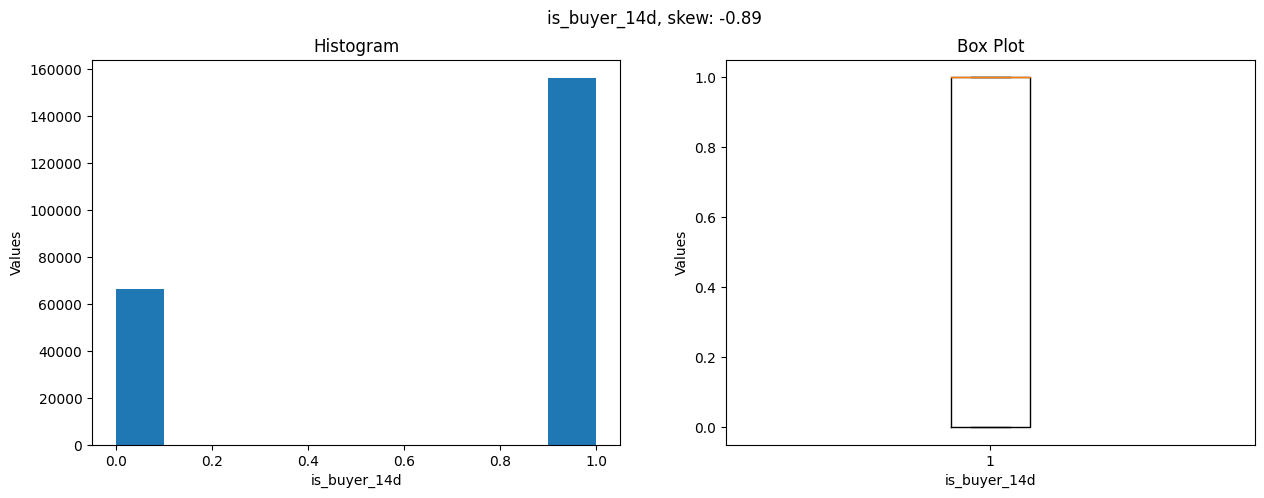

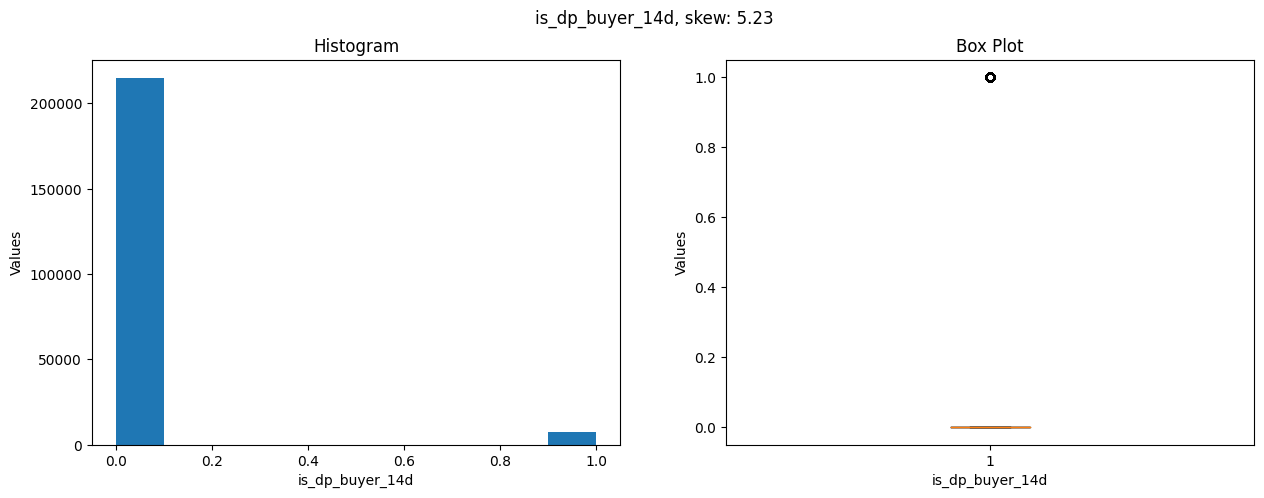

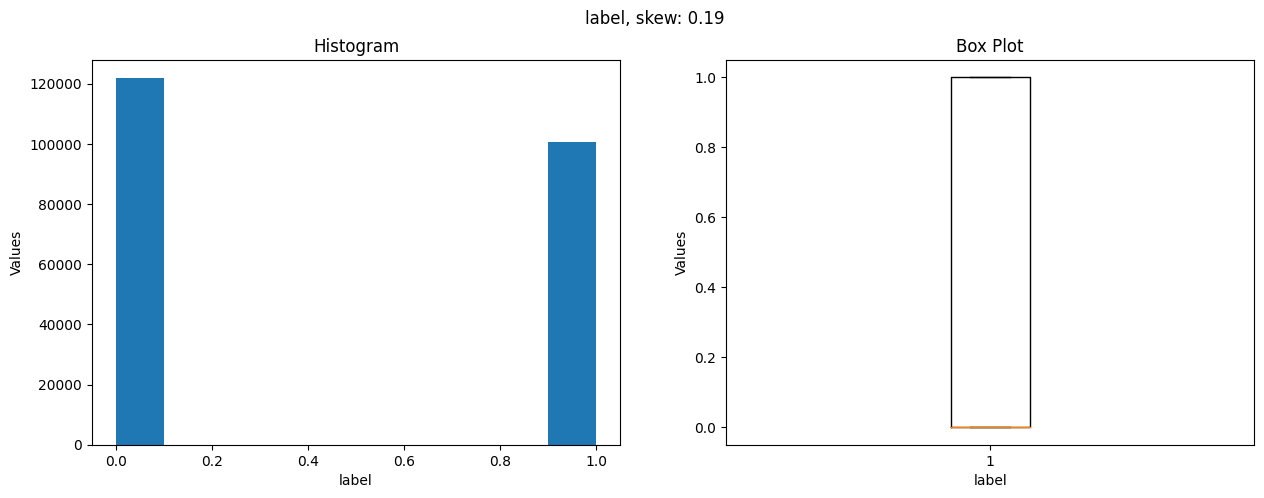

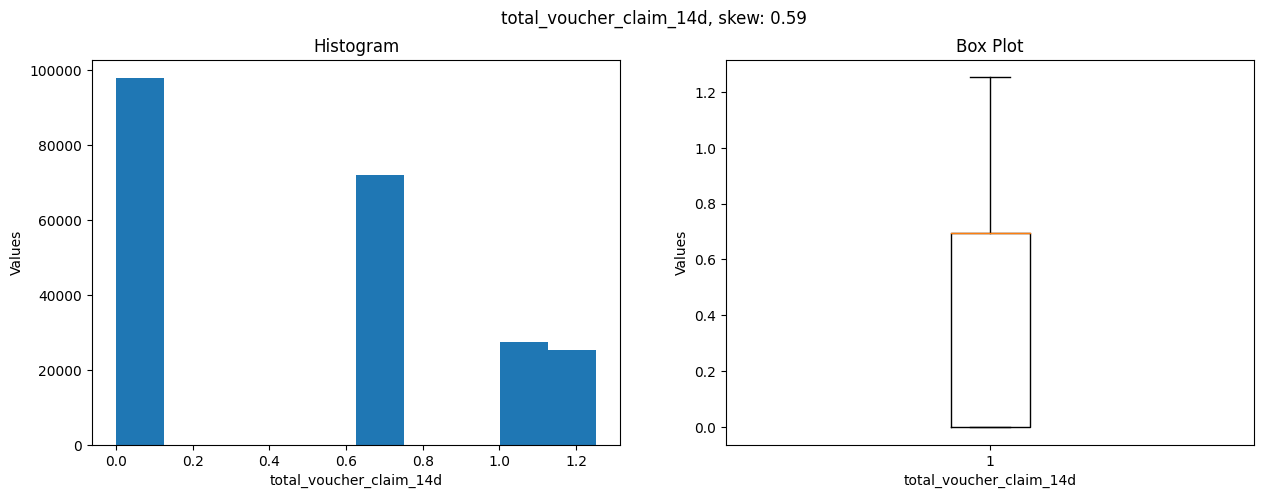

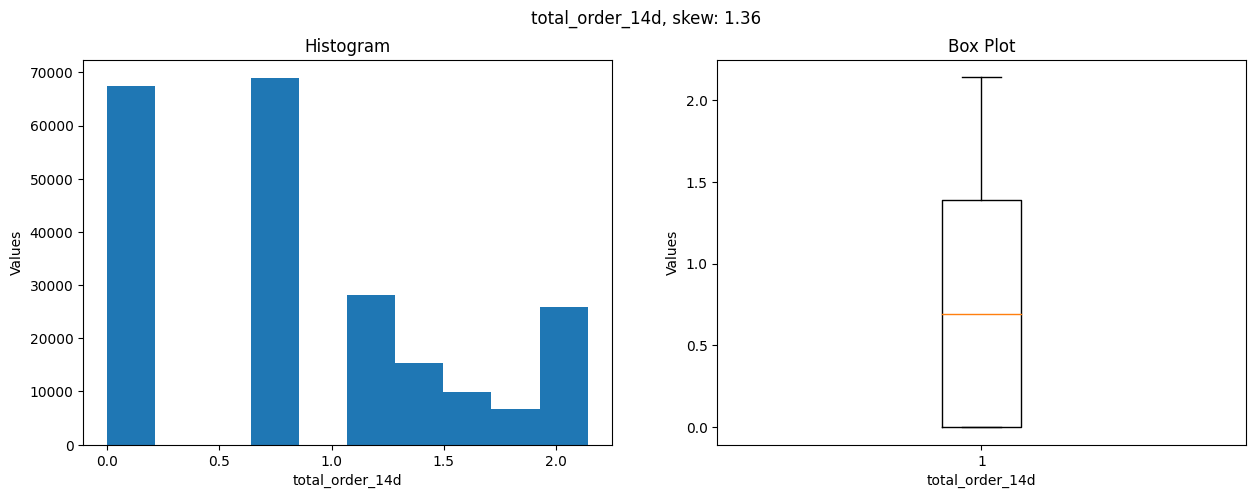

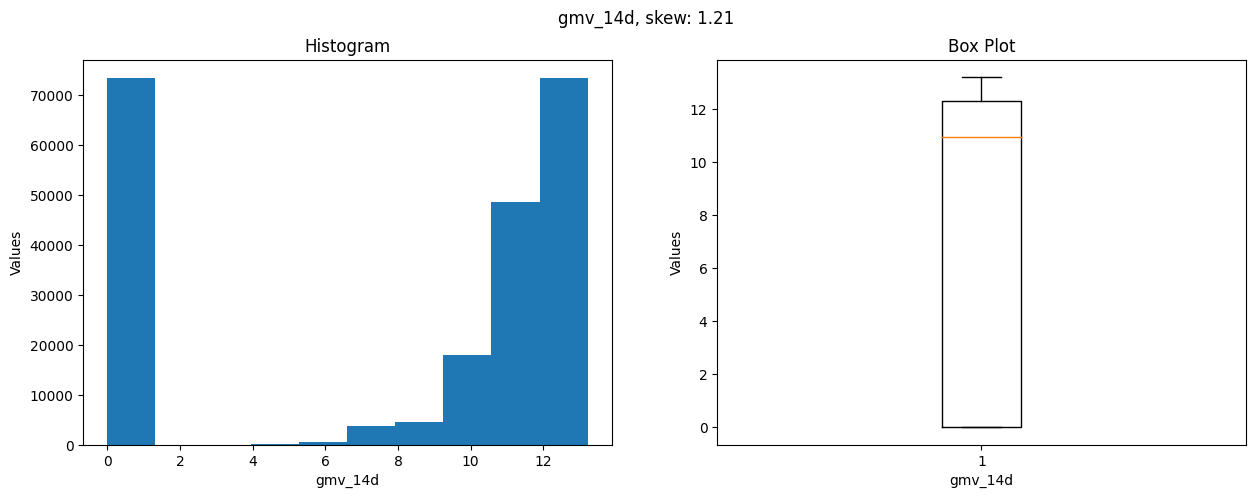

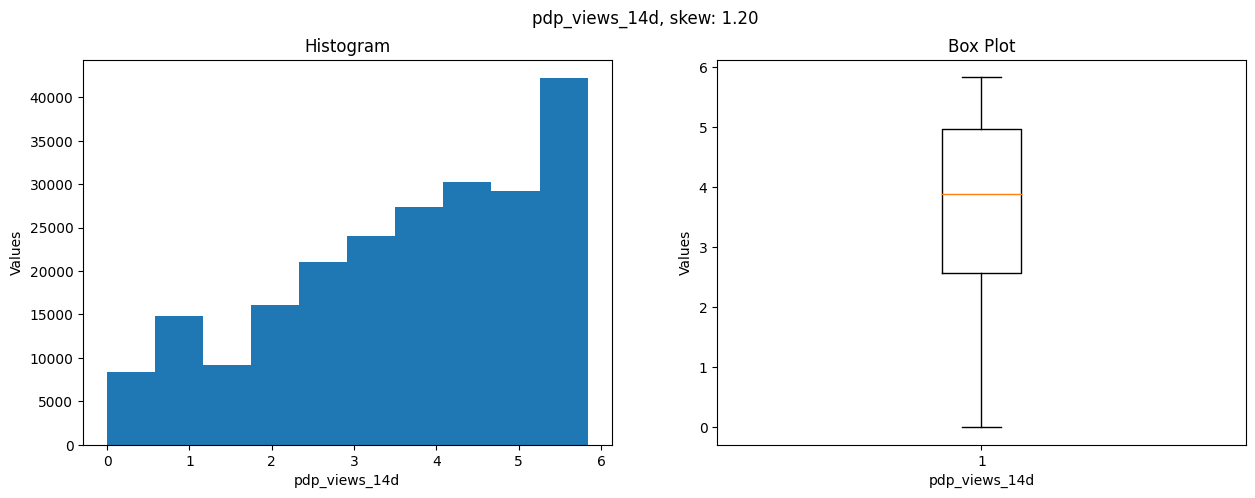

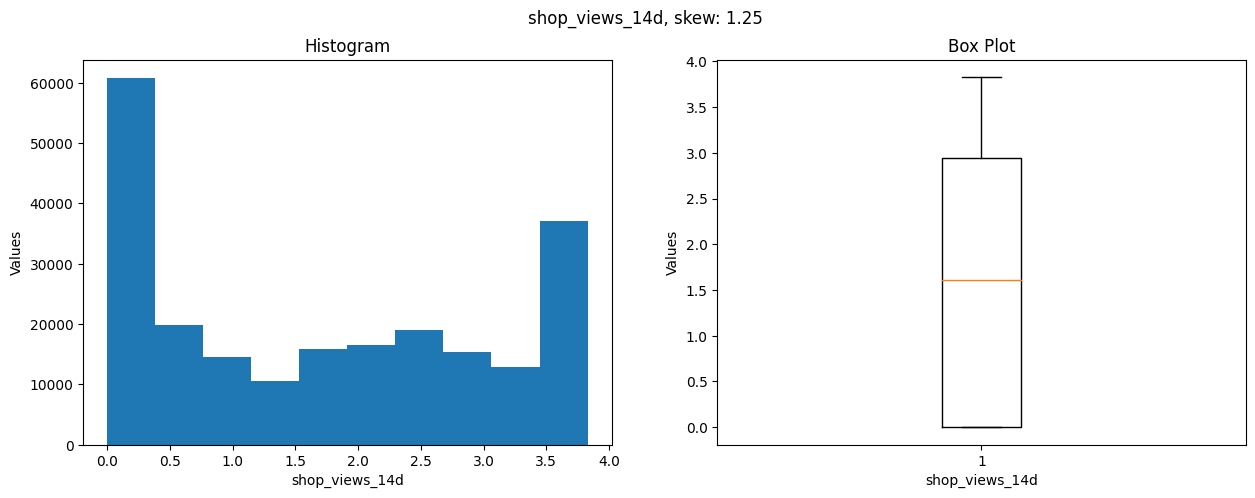

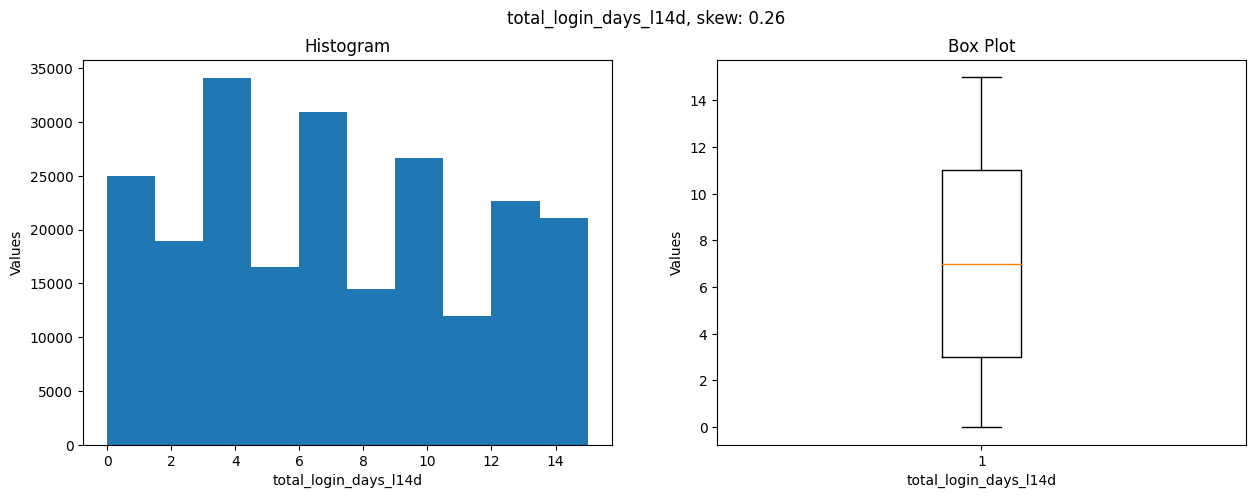

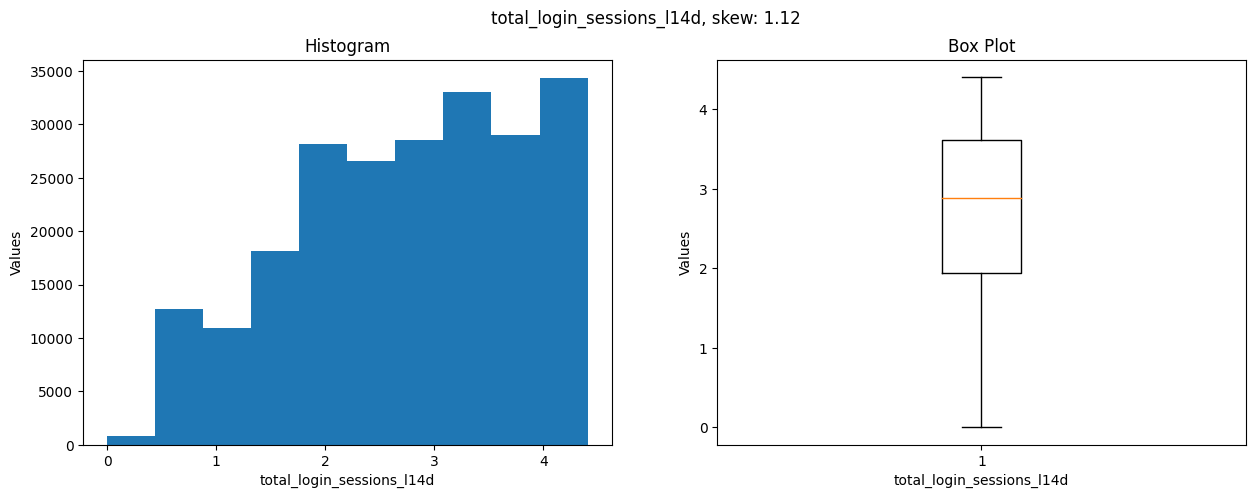

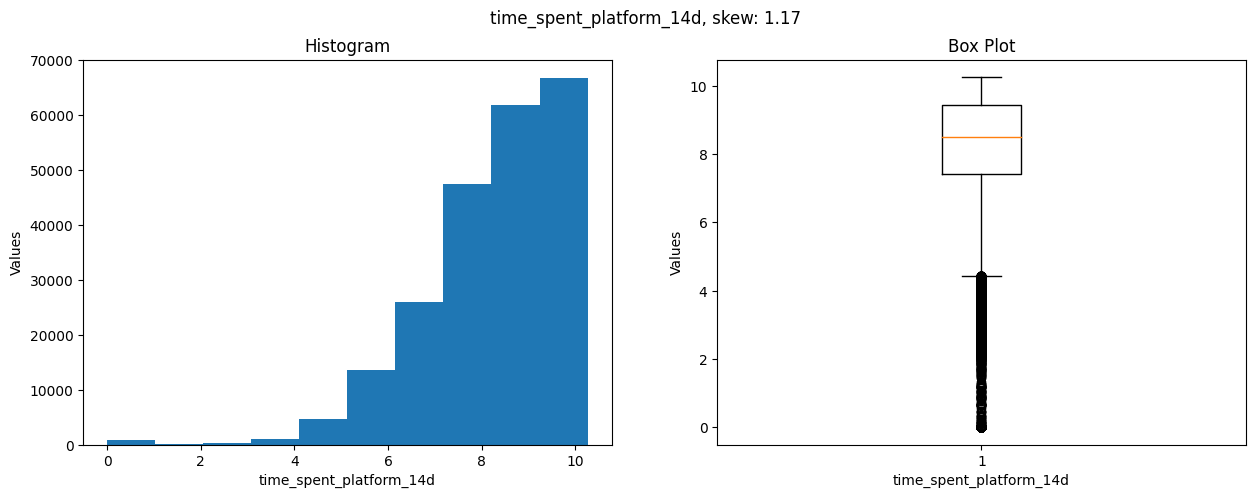

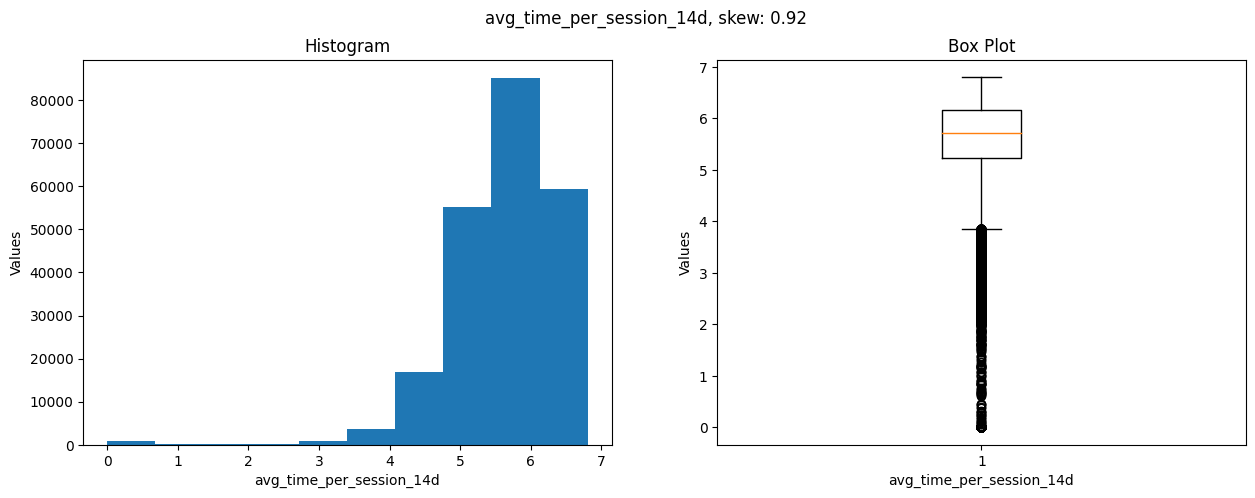

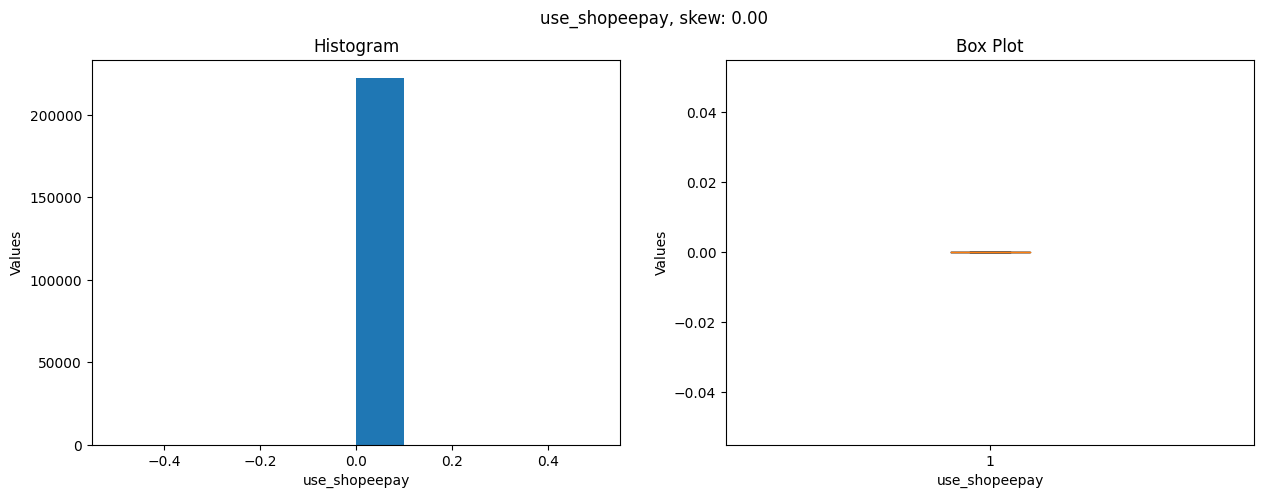

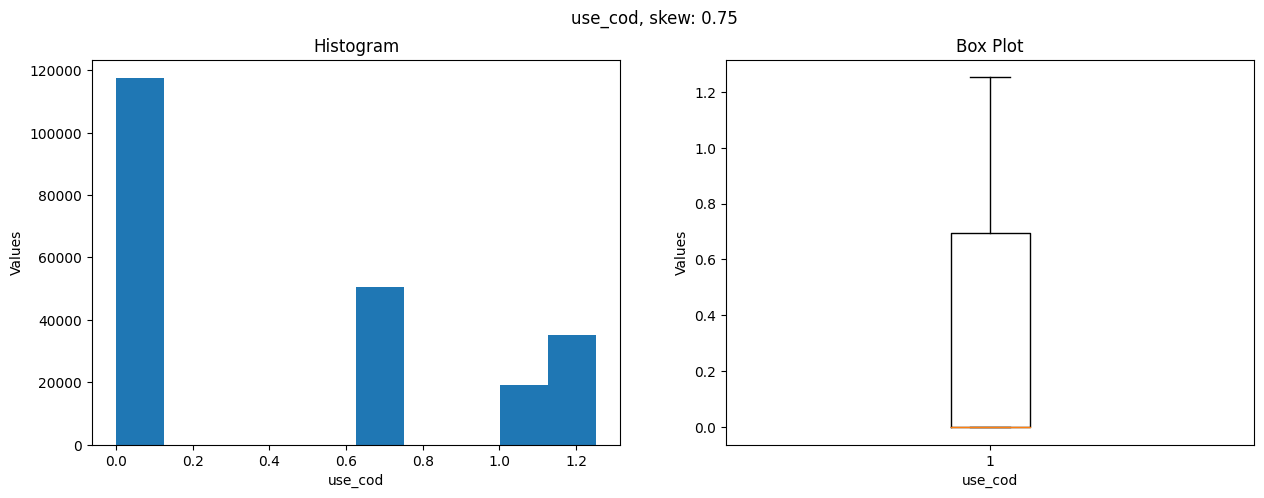

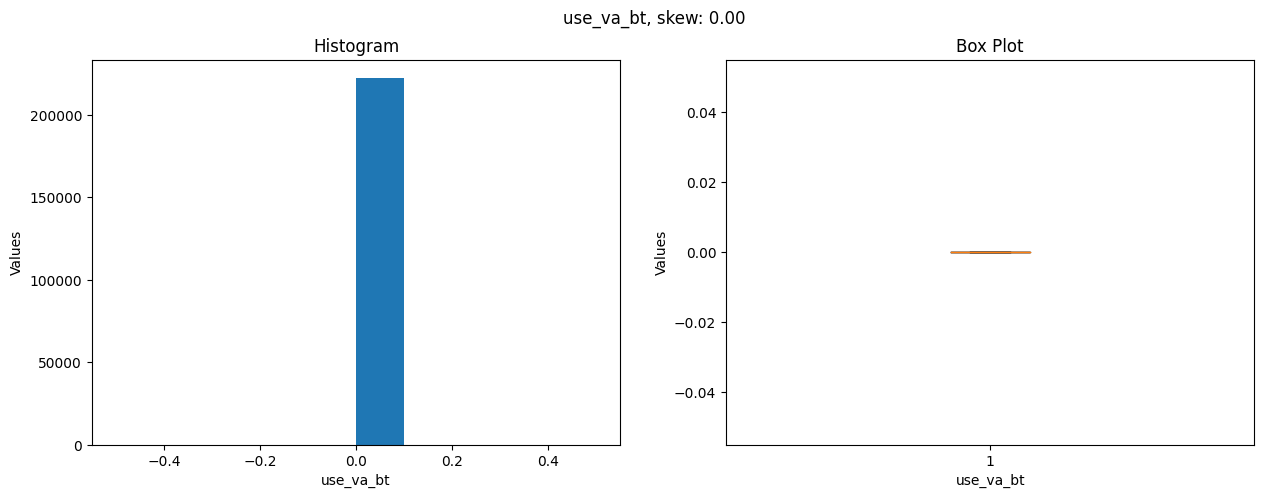

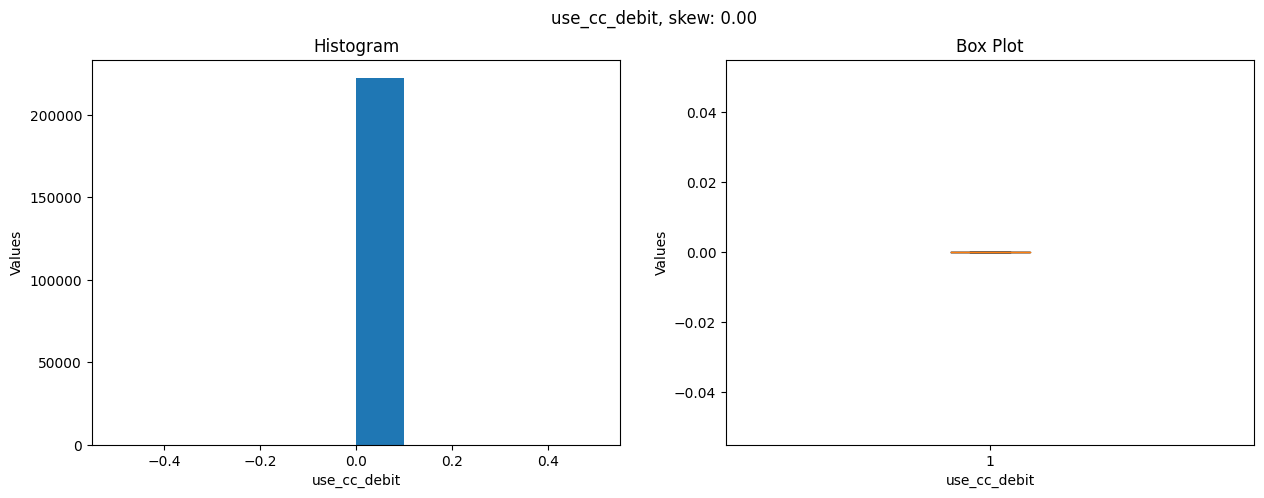

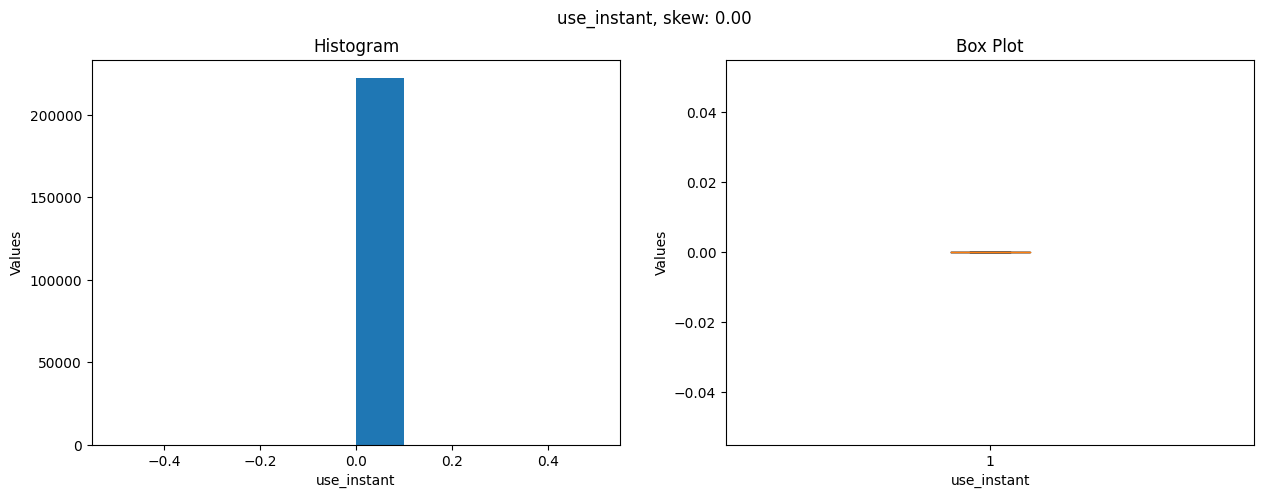

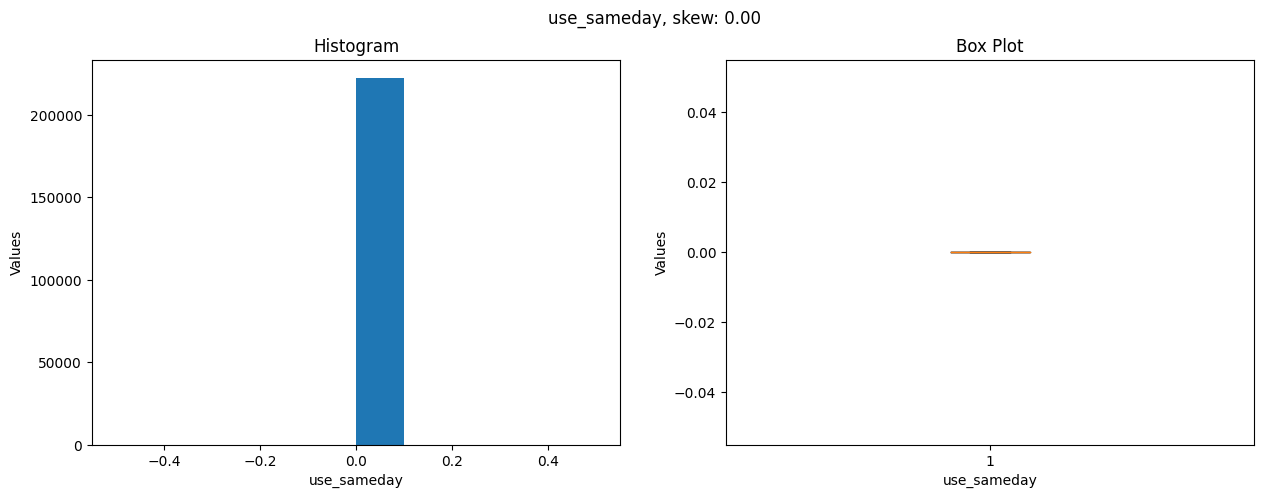

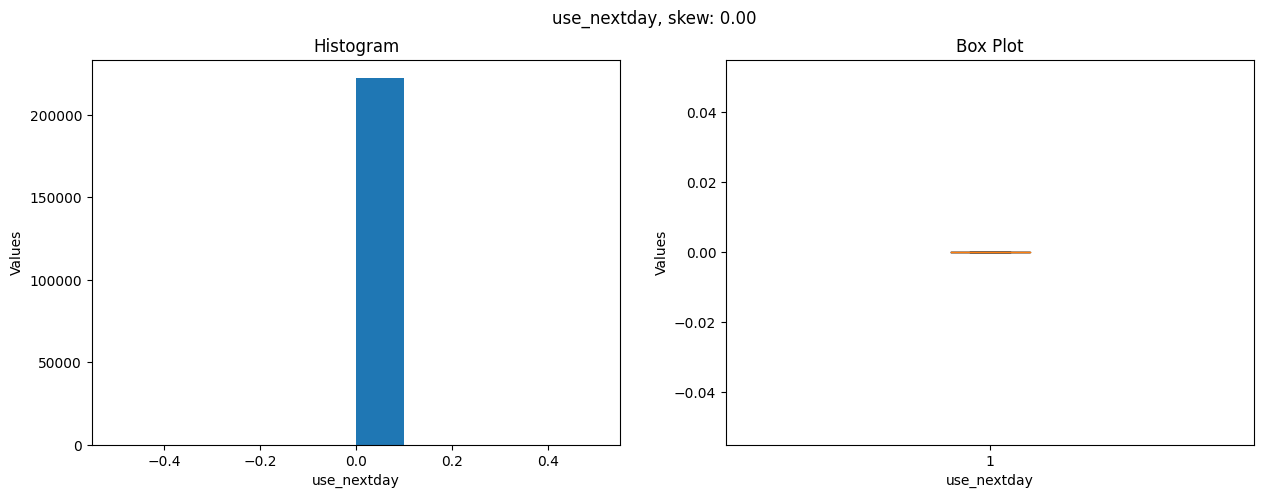

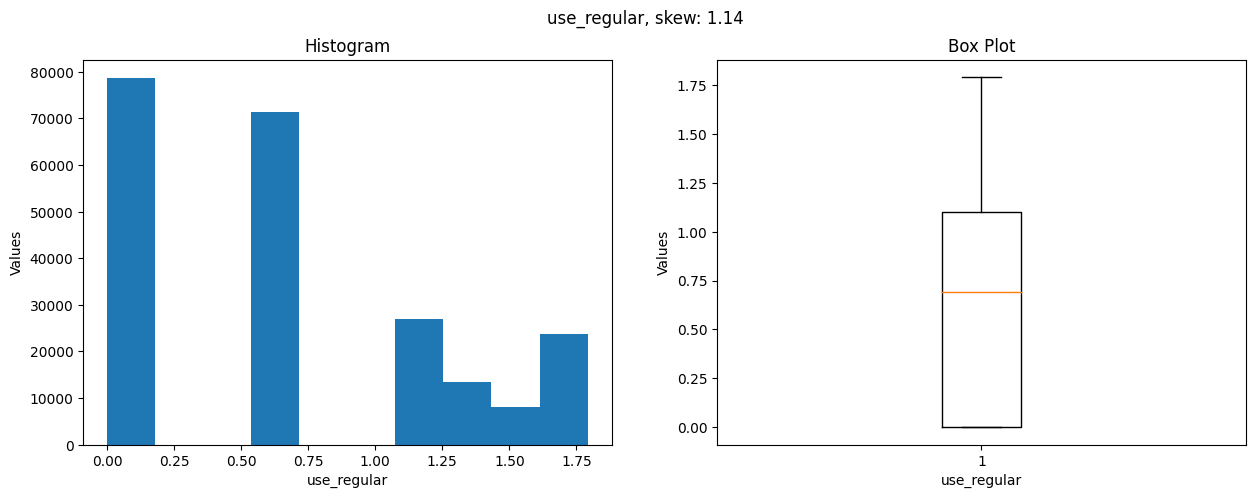

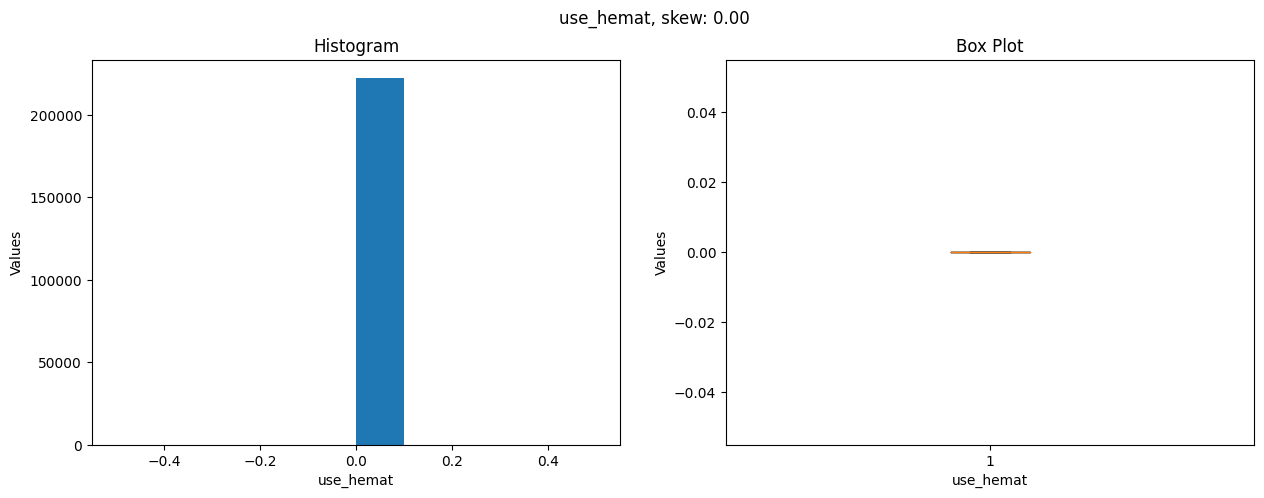

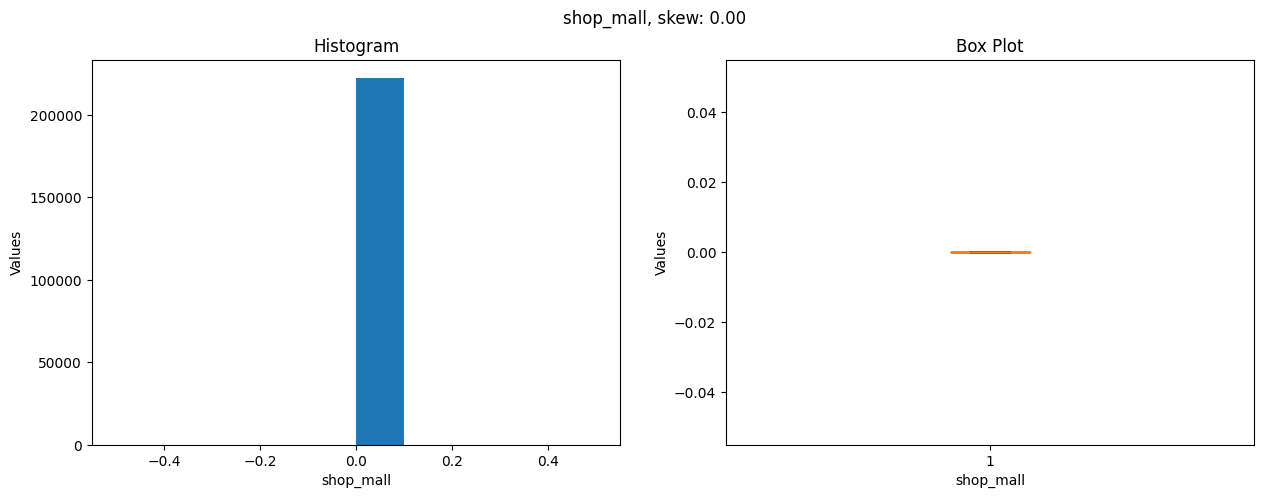

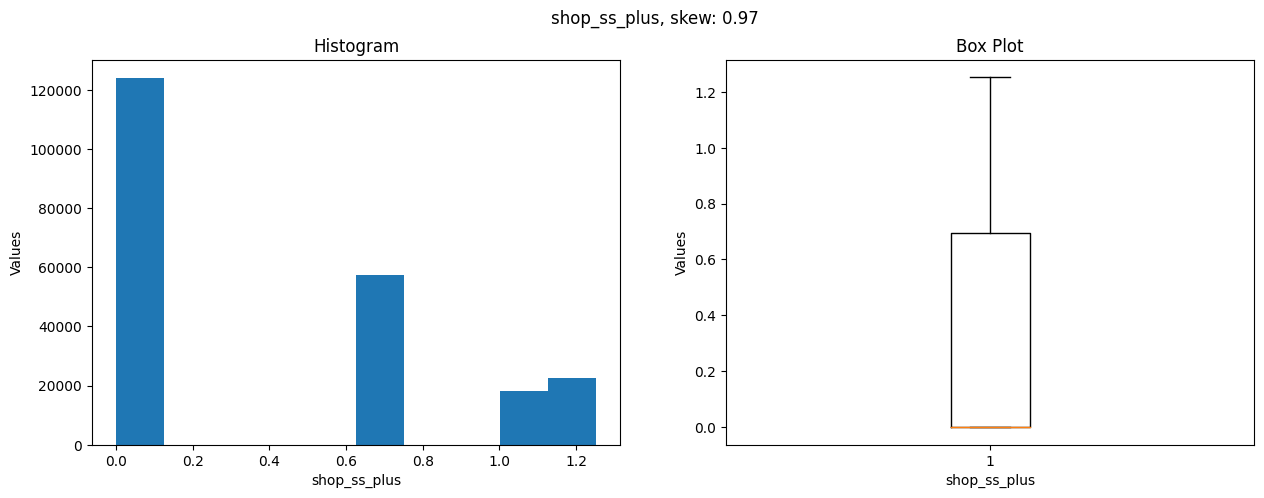

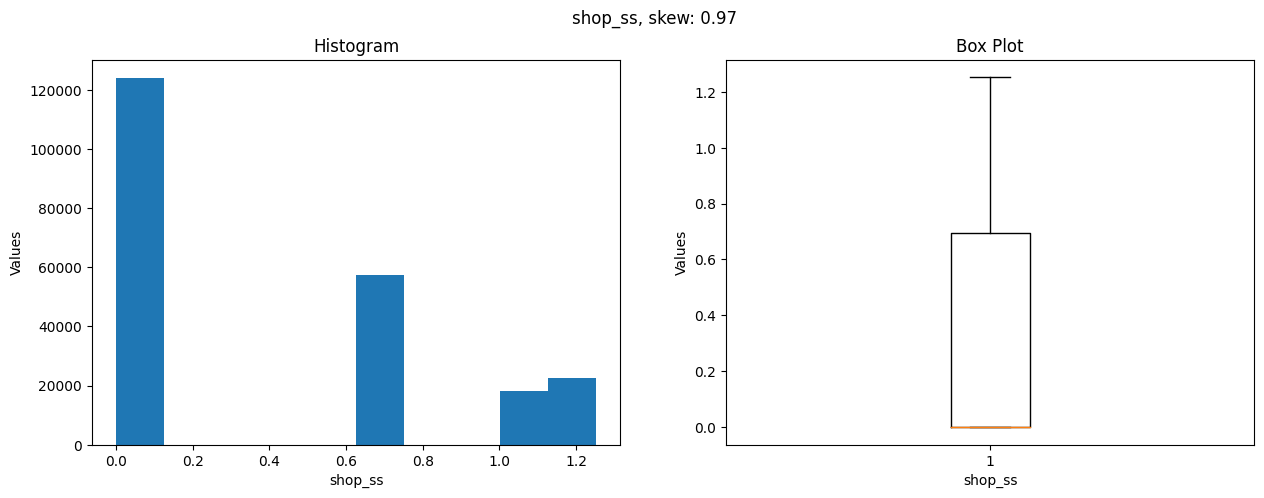

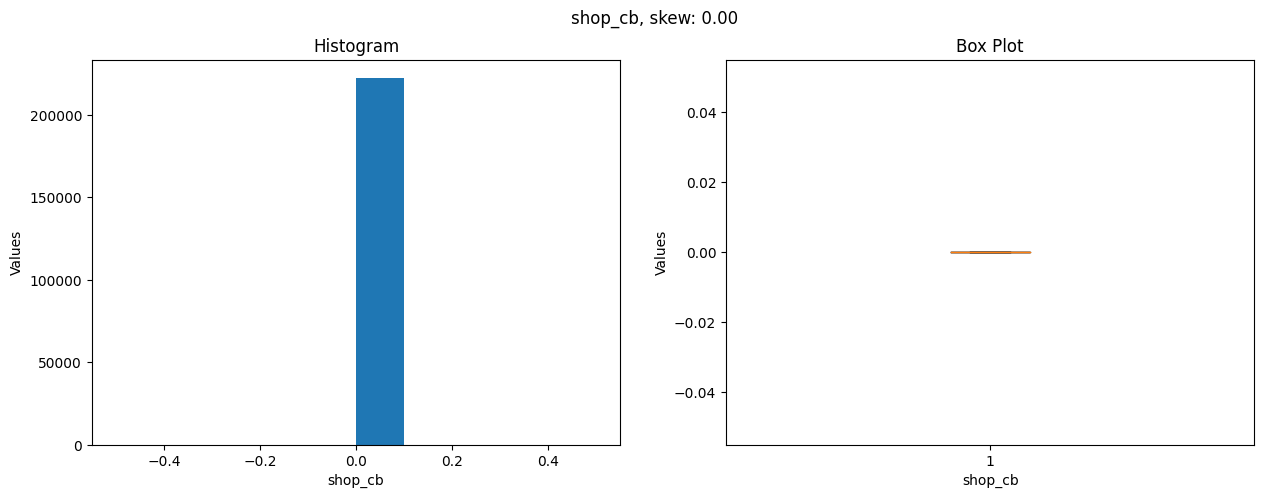

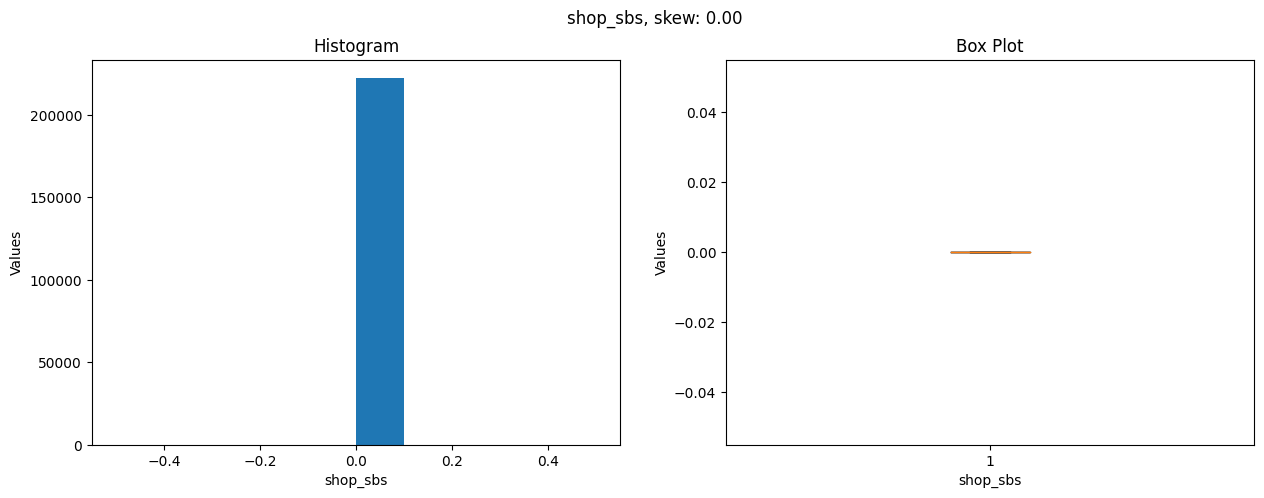

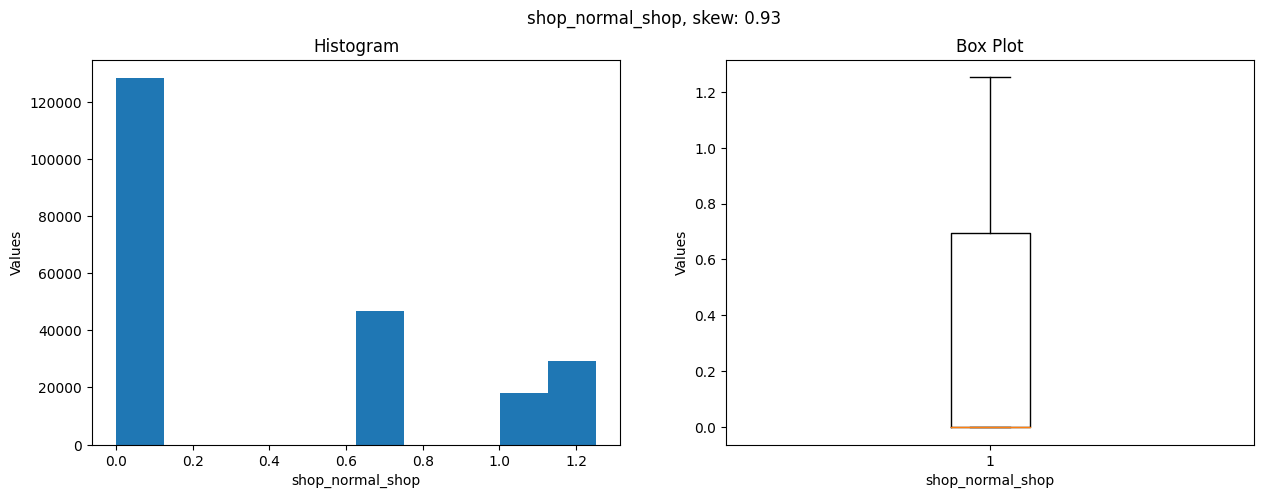

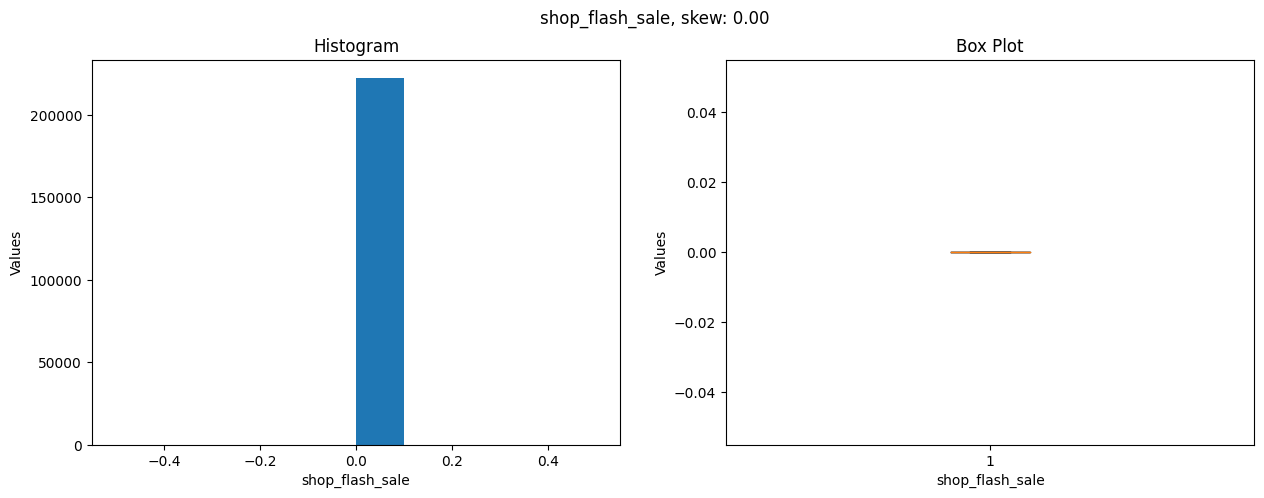

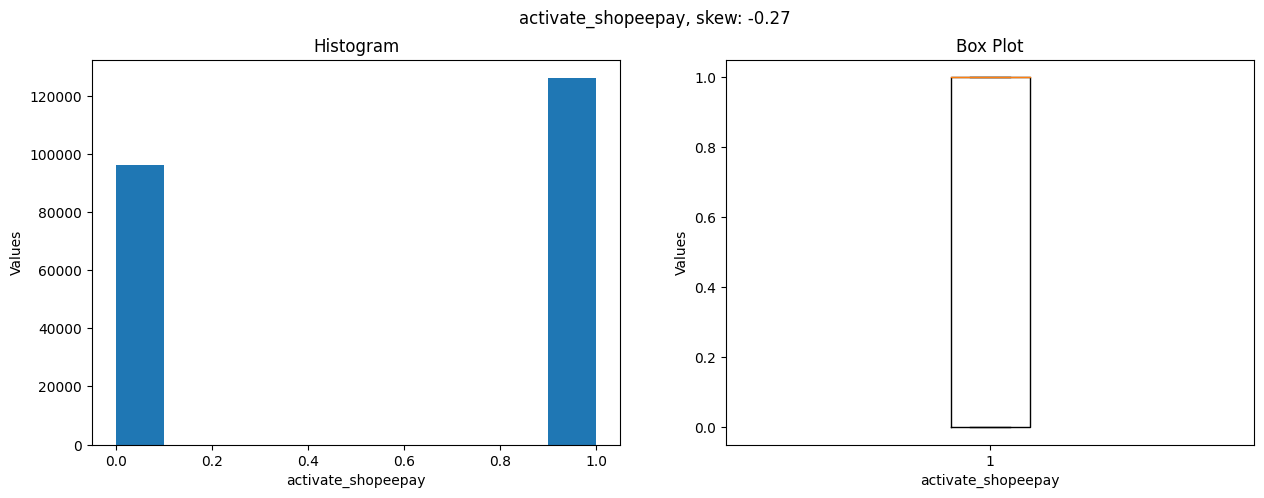

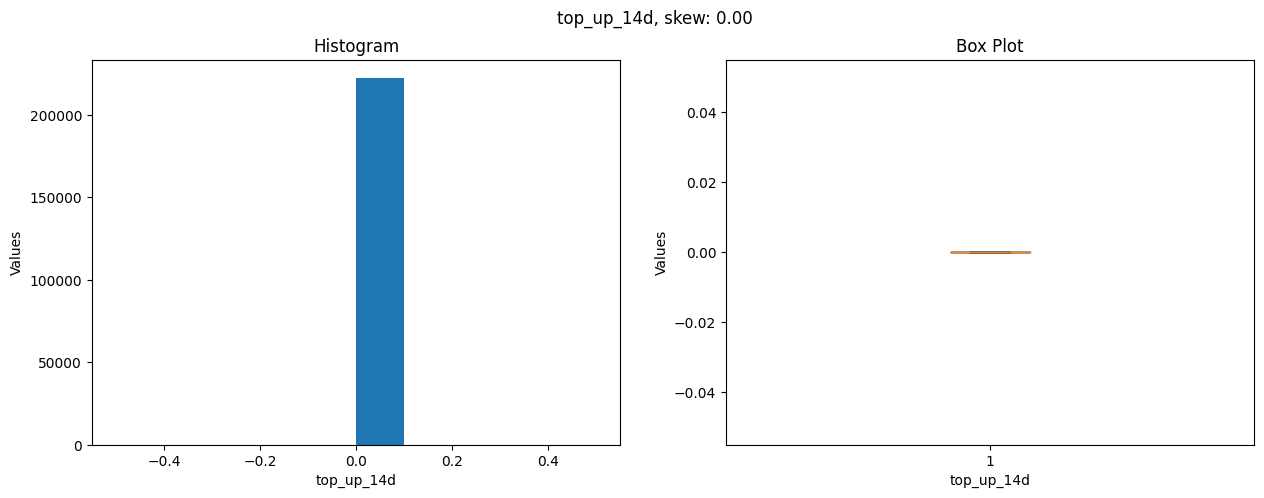

In [ ]:
df = df_ori.copy()
df = clean_data(df)

CAPPING_COLUMNS = [
    "total_voucher_claim_14d",
    "total_order_14d",
    "gmv_14d",
    "pdp_views_14d",
    "shop_views_14d",
    "total_login_sessions_l14d",
    "time_spent_platform_14d",
    "avg_time_per_session_14d",
    "use_shopeepay",
    "use_cod",
    "use_va_bt",
    "use_cc_debit",
    "use_instant",
    "use_sameday",
    "use_nextday",
    "use_regular",
    "use_hemat",
    "shop_mall",
    "shop_ss_plus",
    "shop_ss",
    "shop_cb",
    "shop_sbs",
    "shop_normal_shop",
    "shop_flash_sale",
    "top_up_14d",
]

for col in CAPPING_COLUMNS:
    df[col] = capping_with_iqr(df[col])

# Plot histogram and boxplot
numerical_cols = df.select_dtypes(include=["int", "float"]).columns
print(numerical_cols)
for col in numerical_cols:
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    if col in CAPPING_COLUMNS:
        fig.suptitle(f"{col}, skew: {df[col].skew():.2f}")
        ax[0].hist(df[col].apply(np.log1p))
        ax[0].set_title("Histogram")
        ax[0].set_xlabel(col)
        ax[0].set_ylabel("Values")

        ax[1].boxplot(df[col].apply(np.log1p))
        ax[1].set_title("Box Plot")
        ax[1].set_xlabel(col)
        ax[1].set_ylabel("Values")
    else:
        fig.suptitle(f"{col}, skew: {df[col].skew():.2f}")
        ax[0].hist(df[col])
        ax[0].set_title("Histogram")
        ax[0].set_xlabel(col)
        ax[0].set_ylabel("Values")

        ax[1].boxplot(df[col])
        ax[1].set_title("Box Plot")
        ax[1].set_xlabel(col)
        ax[1].set_ylabel("Values")
    plt.show()

In [ ]:
numerical_cols = df.select_dtypes(include=["int", "float"]).columns
for col in numerical_cols:
    print(f"{col}: {df[col].skew()}")

is_buyer_14d: -0.8864501226936479
is_dp_buyer_14d: 5.2275935478451006
label: 0.1934494567532888
total_voucher_claim_14d: 0.5898022817885378
total_order_14d: 1.3647116714303185
gmv_14d: 1.2128252612047268
pdp_views_14d: 1.197310253907365
shop_views_14d: 1.2484278692726916
total_login_days_l14d: 0.25527662391800077
total_login_sessions_l14d: 1.1159693156854564
time_spent_platform_14d: 1.1684934248961267
avg_time_per_session_14d: 0.923645399775237
use_shopeepay: 0
use_cod: 0.7510297997020341
use_va_bt: 0
use_cc_debit: 0
use_instant: 0
use_sameday: 0
use_nextday: 0
use_regular: 1.1413551117743441
use_hemat: 0
shop_mall: 0
shop_ss_plus: 0.9659096129291042
shop_ss: 0.9659096129291042
shop_cb: 0
shop_sbs: 0
shop_normal_shop: 0.9332770401989515
shop_flash_sale: 0
activate_shopeepay: -0.2716875343094963
top_up_14d: 0


## Check Class Imbalance

In [ ]:
# Check for data imbalance
df["label"].value_counts(normalize=True)

label
0    0.548137
1    0.451863
Name: proportion, dtype: float64

Explanation: There's class imbalance where the amount of 0 class is 9% higher.

**Action to take**: perform random undersampling

# Data Preprocessing

In [ ]:
# Constants
REDUNDANT_COLUMNS = [
    "time_spent_platform_14d",
    "total_login_sessions_l14d"
]
CAPPING_COLUMNS = [
    "total_voucher_claim_14d",
    "total_order_14d",
    "gmv_14d",
    "pdp_views_14d",
    "shop_views_14d",
    "avg_time_per_session_14d",
    "use_shopeepay",
    "use_cod",
    "use_va_bt",
    "use_cc_debit",
    "use_instant",
    "use_sameday",
    "use_nextday",
    "use_regular",
    "use_hemat",
    "shop_mall",
    "shop_ss_plus",
    "shop_ss",
    "shop_cb",
    "shop_sbs",
    "shop_normal_shop",
    "shop_flash_sale",
    "top_up_14d",
]
OHE_COLS = [
    "gender",
    "age_group",
    "region",
    "is_rural_or_urban",
    "new_buyer_initiative",
]
TARGET_COL = "label"


def preprocess_training_features(feature_df: pd.DataFrame) -> pd.DataFrame:
    # 1. Capping outliers
    for col in CAPPING_COLUMNS:
        feature_df[col] = capping_with_iqr(feature_df[col])

    # 2. Drop Redundant Features
    feature_df = feature_df.drop(columns=REDUNDANT_COLUMNS)

    # 3. One Hot Encoding
    ohes = {}
    for col in OHE_COLS:
        ohe = OneHotEncoder(
            categories=[feature_df[col].unique()],
            sparse_output=False,
            handle_unknown="ignore",
        )
        feature_df_encoded = pd.DataFrame(
            ohe.fit_transform(feature_df[[col]])
        )
        feature_df_encoded.columns = ohe.get_feature_names_out([col])
        feature_df = feature_df.drop(columns=[col])
        feature_df = pd.concat([feature_df, feature_df_encoded], axis=1)

        # list the one hot encoder
        ohes[col] = ohe

    # 4. Data Standardization
    feature_names = feature_df.columns
    scaler = StandardScaler()
    feature_df = scaler.fit_transform(feature_df)

    return feature_df, feature_names, ohes, scaler


def preprocess_testing_features(
    feature_df: pd.DataFrame, ohes: dict, scaler: StandardScaler
) -> pd.DataFrame:
    # 1. Capping outliers
    for col in CAPPING_COLUMNS:
        feature_df[col] = capping_with_iqr(feature_df[col])

    # 2. Drop Redundant Features
    feature_df = feature_df.drop(columns=REDUNDANT_COLUMNS)

    # 3. One Hot Encoding
    for col in OHE_COLS:
        ohe = ohes[col]  # one hot encoder
        feature_df_encoded = pd.DataFrame(
            ohe.transform(feature_df[[col]])
        )  # one hot encoding
        feature_df_encoded.columns = ohe.get_feature_names_out([col])
        feature_df = feature_df.drop(columns=[col])
        feature_df = pd.concat([feature_df, feature_df_encoded], axis=1)

    # 4. Data Standardization
    feature_names = feature_df.columns
    feature_df = scaler.transform(feature_df)

    return feature_df, feature_names

Exaplanation about the code:
1. Drop columns `total_login_sessions_l14d` and `time_spent_platform_14d` because both information are already represented by `avg_time_per_session_14d`
2. Perform log transformation on numerical columns with high skew score.
3. Perform one hot encosing on nominal variables
4. Perform standardization scaling.

# Data Preparation

In [ ]:
def get_modelling_data(with_feature_names: bool=False):
    TARGET_COL="label"

    # 1. Data Cleaning
    df = df_ori.copy()
    df = clean_data(df)

    # 2. Data Splitting
    X, y = df.drop(columns=TARGET_COL), df[TARGET_COL]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, shuffle=True, random_state=42
    )
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5, shuffle=True, random_state=42
    )
    X_train, X_valid, X_test = X_train.reset_index(drop=True), X_valid.reset_index(drop=True), X_test.reset_index(drop=True)

    # 3. Random Under Sampling
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    X_valid, y_valid = rus.fit_resample(X_valid, y_valid)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    return (X_train, X_valid, X_test, y_train, y_valid, y_test)

# Data Modelling

## Cross Validation
In cross validation we will be using 3 models: Logistic Regression, LightGBM and XGBoost. The data that will be used is `X_train`

In [ ]:
# 1. Prepare Models
models = [
    LogisticRegression(max_iter=200, random_state=42),
    LGBMClassifier(njobs=-1, verbose=-1, random_state=42),
    XGBClassifier(n_jobs=-1, random_state=42),
]
recall, precision, f1, roc_auc = [], [], [], []
model_names = []

(X_train, X_valid, X_test, y_train, y_valid, y_test) = get_modelling_data()

# 2. Cross Validation
for model in models:
    # 2.1. Perform Cross Validation Splitting
    ss = StratifiedShuffleSplit(n_splits=5)
    temp_recall, temp_precision, temp_f1, temp_roc_auc = [], [], [], []


    for train_index, val_index in ss.split(X_train, y_train):
        # 2.1.1. Split based on generated index of folding
        X_train_fold, X_val_fold = X_train.iloc[train_index].reset_index(
            drop=True
        ), X_train.iloc[train_index].reset_index(drop=True)
        y_train_fold, y_val_fold = (
            y_train.iloc[train_index].values.ravel(),
            y_train.iloc[train_index].values.ravel(),
        )

        # 2.1.2. Preprocess training and validation data
        X_train_fold_preprocessed, feature_names, ohes, scaler = (
            preprocess_training_features(X_train_fold)
        )
        X_val_fold_preprocessed, feature_names = preprocess_testing_features(
            feature_df=X_val_fold, ohes=ohes, scaler=scaler
        )

        # 2.1.3. Train model
        cv_model = clone(model)
        cv_model.fit(X_train_fold_preprocessed, y_train_fold)

        # 2.1.4. Predict & evaluate model
        y_val_fold_pred = cv_model.predict(X_val_fold_preprocessed)
        temp_recall.append(recall_score(y_val_fold_pred, y_val_fold))
        temp_precision.append(precision_score(y_val_fold_pred, y_val_fold))
        temp_f1.append(f1_score(y_val_fold_pred, y_val_fold))
        temp_roc_auc.append(roc_auc_score(y_val_fold_pred, y_val_fold))

    # 2.2. Record for Final Summary
    model_names.append(cv_model.__class__.__name__)
    recall.append(np.mean(temp_recall))
    precision.append(np.mean(temp_precision))
    f1.append(np.mean(temp_f1))
    roc_auc.append(np.mean(temp_roc_auc))
    print(f"{cv_model.__class__.__name__} done")

# 3. Display cross validation results
pd.DataFrame(
    {
        "model": model_names,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "roc_auc": roc_auc,
    }
).sort_values(by=["roc_auc"])

LogisticRegression done
LGBMClassifier done
XGBClassifier done


model    recall  precision        f1   roc_auc
0  LogisticRegression  0.717659   0.748381  0.732698  0.727393
1      LGBMClassifier  0.726383   0.780724  0.752572  0.744689
2       XGBClassifier  0.746787   0.790748  0.768139  0.762224

Explanation about the code:
1. Perform cross validation scoring manually so that we can incorporate multiple metrics at the same time.
2. Cross validation scoring only for training data (`X_train`)
3. The purpose of cross validation is to pick what is the suitable model for this problem. But since our model is not that many we can just choose all of them

# Model Improvement

In [ ]:
# 1. Prepare data
(X_train, X_valid, X_test, y_train, y_valid, y_test) = get_modelling_data()

# 2. Perform data preprocessing
X_train_preprocessed, feature_names, ohes, scaler = preprocess_training_features(
    X_train
)
X_valid_preprocessed, feature_names = preprocess_testing_features(
    feature_df=X_valid, ohes=ohes, scaler=scaler
)
X_test_preprocessed, feature_names = preprocess_testing_features(
    feature_df=X_test, ohes=ohes, scaler=scaler
)

# 3. Add column names to the data
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_valid_preprocessed = pd.DataFrame(X_valid_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

## Feature Selection
Feature selection will be conducted using SHAP values method which represents the contribution of each features to the final prediction. In the end top 11 features will be selected for efficiency in hyperparameter tuning.

In [ ]:
# 1. Prepare Model
gbc_clf = GradientBoostingClassifier(random_state=42)

# 2. Train Model
gbc_clf.fit(X_train_preprocessed, y_train)

# 3. Calculate SHAP values
gbc_explainer = shap.Explainer(
    gbc_clf, X_train_preprocessed, feature_names=feature_names
)

gbc_shap_values = gbc_explainer(X_train_preprocessed)

100%|===================| 160267/160734 [03:51<00:00]       

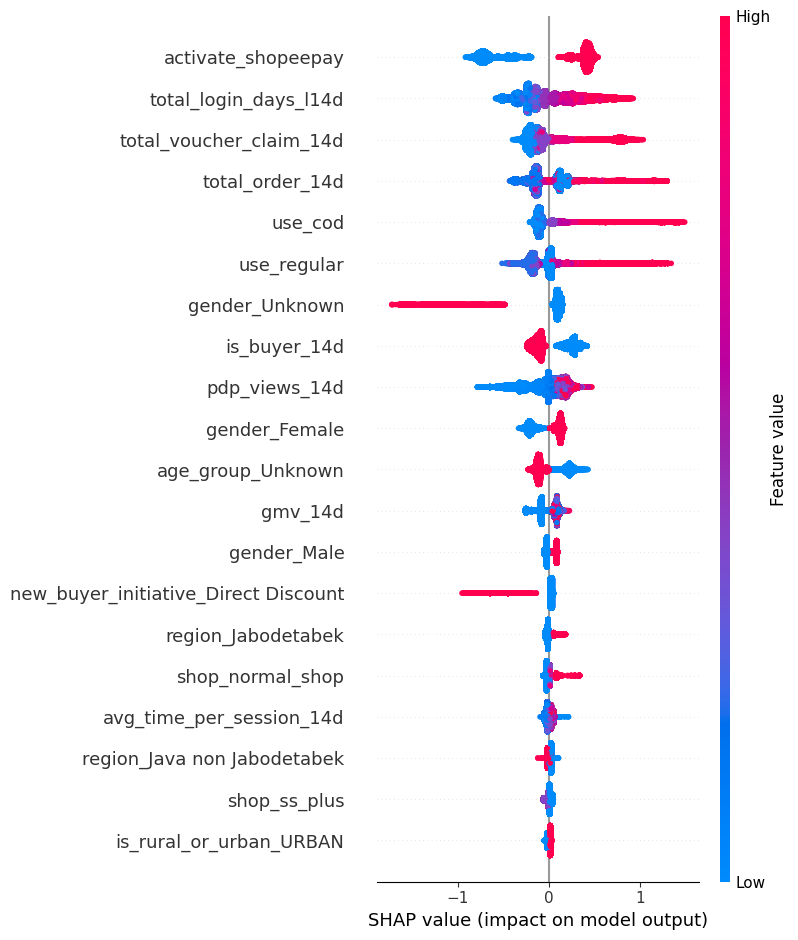

In [ ]:
shap.summary_plot(gbc_shap_values, max_display=20)

The features on the figure plot already sorted in descending order based on how importance that the feature brings to the prediction.

The graph could be interpreted in this way, for example:
1. High **feature value** of `activate_shopeepay` gives positive shap values which leads to increase in probability of predicting customer as retained customer. Other examples with the same interpretation are `use_regular`, `use_cod`, `total_login_days_l14d`, `total_voucher_claim_14d`, etc.
2. High **feature value** of `gender_Unknown` gives positive shap values which leads to decrease in probability of predicting customer as retained customer. This leads that if the gender is unknown, they may didn't fill the profile description which suggest they only visit the applicaton and didn't plan to engage in the application.

But for we want to grab the value that are important to the model:
1. `activate_shopeepay`
2. `total_login_days_l14d`
3. `total_voucher_claim_14d`
4. `total_order_14d`
5. `use_regular`
6. `use_cod`
7. `gender_Unknown`
8. `is_buyer_14d`
9. `pdp_views_14d`
10. `gender_Female`
11. `age_group_Unknown`


## Hyperparameter Tuning

In [ ]:
# 1. Prepare data
(X_train, X_valid, X_test, y_train, y_valid, y_test) = get_modelling_data()

# 2. Perform data preprocessing
X_train_preprocessed, feature_names, ohes, scaler = preprocess_training_features(
    X_train
)
X_valid_preprocessed, feature_names = preprocess_testing_features(
    feature_df=X_valid, ohes=ohes, scaler=scaler
)
X_test_preprocessed, feature_names = preprocess_testing_features(
    feature_df=X_test, ohes=ohes, scaler=scaler
)

# 3. Add column names to the data
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_valid_preprocessed = pd.DataFrame(X_valid_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# 4. Define Selected Features
best_features = [
    "activate_shopeepay",
    "total_login_days_l14d",
    "total_voucher_claim_14d",
    "total_order_14d",
    "use_regular",
    "use_cod",
    "gender_Unknown",
    "is_buyer_14d",
    "pdp_views_14d",
    "gender_Female",
    "age_group_Unknown",
]

### Logistic Regression
Parameters that will be tuned are:
1. `C` represents the regularization strength in inverse manner where lower values indicating a string regulatization and higher values otherwise. Finding the best `C` parameter will prevent model from overfitting and increase its generalization performance.
2. `solver` represents optimization algorithms. Selecting an appropriate algorithm will yield a better performance of Logistic Regression.

In [ ]:
# Logistic Regression Hyperparameter Tuning
def objective(trial):
    params = {
        "max_iter": 200,
        "C": trial.suggest_float("C", 0, 1.0),
        "solver": trial.suggest_categorical(
            "solver", ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]
        ),
        "n_jobs": -1,
        "random_state": 42,
    }

    model = LogisticRegression(**params)
    model.fit(X_train_preprocessed[best_features], y_train)
    y_pred_proba = model.predict_proba(X_valid_preprocessed[best_features])
    return roc_auc_score(y_valid, y_pred_proba[:, 1])


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("\tValue: {}".format(trial.value))
print("\tParams: ")
for key, value in trial.params.items():
    print("\t{}: {}".format(key, value))

[I 2024-04-05 08:14:21,906] A new study created in memory with name: no-name-dee8291e-e168-416c-bb96-38260e1eb92d
[I 2024-04-05 08:14:23,385] Trial 0 finished with value: 0.7956168299126823 and parameters: {'C': 0.32153201223221317, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7956168299126823.
[I 2024-04-05 08:14:24,234] Trial 1 finished with value: 0.795617573060002 and parameters: {'C': 0.04438374840233528, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.795617573060002.
[I 2024-04-05 08:14:25,680] Trial 2 finished with value: 0.7956138870492966 and parameters: {'C': 0.013815004275579135, 'solver': 'sag'}. Best is trial 1 with value: 0.795617573060002.
[I 2024-04-05 08:14:27,648] Trial 3 finished with value: 0.7956161263998864 and parameters: {'C': 0.2745805048094476, 'solver': 'sag'}. Best is trial 1 with value: 0.795617573060002.
[I 2024-04-05 08:14:28,991] Trial 4 finished with value: 0.7956169488162537 and parameters: {'C': 0.9353232122287022, 'solver': 'lbfgs'}. Best is 

Number of finished trials:  50
Best trial:
	Value: 0.7956197331415444
	Params: 
	C: 0.696340612092542
	solver: sag


### LightGBM
Parameters that will be tuned are:
1. `learning_rate` which controls how the model learn the input data. Learning rate impacts the model in either overfitting or underfitting. Finding the sweet spot for the learning rate can prevent both scenarios.
2. `num_leaves` which controls how much number of terminal nodes in each tree. Increasing the amount of number leaves lead to a more flexible model that can capture complex patterns in the data. But be careful of overfitting.
3. `subsample` which controls how much proportion from the training data that will be randomly sampled for training weak learner (decision tree). Subsample help in reducing overfitting by introduction each tree with diversity subset of the training data.
4. `colsample_bytree` which controls how much proportion from the features will be picked for training weak learner. Also help in reducing overfitting
5. `min_data_in_leaf` which controls minimum amount of samples in each leave. This also prevent overfitting by reducing noise (leaves with small samples)
6. `bagging_freq` to one which ensures data resampling for each model creation.

In [ ]:
# LightGBM Hyperparameter Tuning
import lightgbm as lgb  # using lgb to increase speed of hyperparameter tuning
def objective(trial):
    params = {
        "objective": "binary",
        "n_iterations": 500,
        "verbosity": -1,
        "bagging_freq": 1,
        "random_state": 42,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2*200),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    dtrain = lgb.Dataset(X_train_preprocessed[best_features], label=y_train)
    lgb_clf = lgb.train(params, dtrain)
    y_pred_proba = lgb_clf.predict(X_valid_preprocessed[best_features])
    return roc_auc_score(y_valid, y_pred_proba)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("\tValue: {}".format(trial.value))
print("\tParams: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-05 08:15:41,170] A new study created in memory with name: no-name-a76f4537-49c1-4f21-906a-ef9928a24322
[I 2024-04-05 08:15:45,877] Trial 0 finished with value: 0.8176232402816446 and parameters: {'learning_rate': 0.004206878624705215, 'num_leaves': 233, 'subsample': 0.731487139522145, 'colsample_bytree': 0.7986554939695601, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.8176232402816446.
[I 2024-04-05 08:15:48,709] Trial 1 finished with value: 0.8167585735122717 and parameters: {'learning_rate': 0.07551357739305066, 'num_leaves': 241, 'subsample': 0.535951320270487, 'colsample_bytree': 0.5114580511876197, 'min_data_in_leaf': 73}. Best is trial 0 with value: 0.8176232402816446.
[I 2024-04-05 08:15:51,260] Trial 2 finished with value: 0.8149864396422286 and parameters: {'learning_rate': 0.002022906614533515, 'num_leaves': 68, 'subsample': 0.4146753254344496, 'colsample_bytree': 0.6689632810734841, 'min_data_in_leaf': 90}. Best is trial 0 with value: 0.8176232402816446.


Number of finished trials:  50
Best trial:
	Value: 0.8190130942161378
	Params: 
    learning_rate: 0.07577948522634759
    num_leaves: 82
    subsample: 0.9507082406139593
    colsample_bytree: 0.7367869775427891
    min_data_in_leaf: 34


### XGBoost
Parameters that will be tuned are:
1. `learning_rate` which controls how the model learn the input data. Learning rate impacts the model in either overfitting or underfitting. Finding the sweet spot for the learning rate can prevent both scenarios.
2. `max_depth` which controls how much deep can the tree could go. Increasing the  depth enables capturing complex patterns in the data. Aware of overfitting.
3. `subsample` which controls how much proportion from the training data that will be randomly sampled for training weak learner (decision tree). Subsample help in reducing overfitting by introduction each tree with diversity subset of the training data.
4. `colsample_bytree` which controls how much proportion from the features will be picked for training weak learner. Also help in reducing overfitting
5. `min_child_weight` which controls the splitting of decision nodes by making sure that

In [ ]:
# XGBoost Hyperparameter Tuning
import xgboost as xgb  # using lgb to increase speed of hyperparameter tuning

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "n_estimators": 500,
        "random_state": 42,
        "verbosity": 0,
        "booster": "gbtree",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    dtrain = xgb.DMatrix(X_train_preprocessed[best_features], label=y_train)
    dvalid = xgb.DMatrix(X_valid_preprocessed[best_features], label=y_valid)
    xgb_clf = xgb.train(params, dtrain)
    y_pred_proba = xgb_clf.predict(dvalid)
    return roc_auc_score(y_valid, y_pred_proba)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("\tValue: {}".format(trial.value))
print("\tParams: ")
for key, value in trial.params.items():
    print("\t\t{}: {}".format(key, value))

[I 2024-04-05 08:17:59,648] A new study created in memory with name: no-name-603c6df9-e1a5-4996-b183-303de412bb4a
[I 2024-04-05 08:17:59,995] Trial 0 finished with value: 0.8090069474960274 and parameters: {'learning_rate': 0.0034305105178906625, 'max_depth': 10, 'subsample': 0.2058493440088786, 'colsample_bytree': 0.6550475881046001, 'min_child_weight': 8}. Best is trial 0 with value: 0.8090069474960274.
[I 2024-04-05 08:18:00,215] Trial 1 finished with value: 0.7672853093964062 and parameters: {'learning_rate': 0.0020755827265705098, 'max_depth': 2, 'subsample': 0.383372268137998, 'colsample_bytree': 0.30320996993862315, 'min_child_weight': 20}. Best is trial 0 with value: 0.8090069474960274.
[I 2024-04-05 08:18:00,463] Trial 2 finished with value: 0.7404894978618959 and parameters: {'learning_rate': 0.0012141407411984568, 'max_depth': 5, 'subsample': 0.4003527366948224, 'colsample_bytree': 0.09899785275879328, 'min_child_weight': 16}. Best is trial 0 with value: 0.8090069474960274.


Number of finished trials:  50
Best trial:
	Value: 0.8153531085297497
	Params: 
		learning_rate: 0.011522959821568502
		max_depth: 9
		subsample: 0.9632475369168552
		colsample_bytree: 0.7766358063555726
		min_child_weight: 9


# Model Comparison

In [ ]:
# Set up best params
best_log_reg_params = {
    "max_iter": 200,
    "random_state": 42,
    "C": 0.696340612092542,
	"solver": "sag",
    "n_jobs": -1,
}

best_lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "n_iterations": 500,
    "verbosity": -1,
    "bagging_freq": 1,
    "random_state": 42,
    "boosting_type": "gbdt",
    "learning_rate": 0.07577948522634759,
    "num_leaves": 82,
    "subsample": 0.9507082406139593,
    "colsample_bytree": 0.7367869775427891,
    "min_data_in_leaf": 34
}

best_xgb_params = {
    "objective": "binary:logistic",
    "n_estimators": 500,
    "random_state": 42,
    "verbosity": 0,
    "booster": "gbtree",
    "learning_rate": 0.011522959821568502,
    "max_depth": 9,
    "subsample": 0.9632475369168552,
    "colsample_bytree": 0.7766358063555726,
    "min_child_weight": 9
}

# Train and predict
models = [
    LogisticRegression(**best_log_reg_params),
    LGBMClassifier(**best_lgb_params),
    XGBClassifier(**best_xgb_params)
]
prediction_outputs = {}

for model in models:
    print(model.__class__.__name__)
    start = time.perf_counter()
    model.fit(pd.concat([X_train_preprocessed, X_valid_preprocessed])[best_features], pd.concat([y_train, y_valid]))
    print(f"Training time: {time.perf_counter()-start}")

    start = time.perf_counter()
    y_pred_proba = model.predict_proba(X_test_preprocessed[best_features])[:, 1]
    print(f"Inference time: {time.perf_counter()-start}")
    prediction_outputs[model.__class__.__name__] = y_pred_proba

LogisticRegression
Training time: 3.3735600019999765
Inference time: 0.005472487000588444
LGBMClassifier
Training time: 2.536809072000324
Inference time: 0.19971381800041854
XGBClassifier
Training time: 11.463747151000462
Inference time: 0.4570326829998521


# Model Comparison

## Confusion Matrix

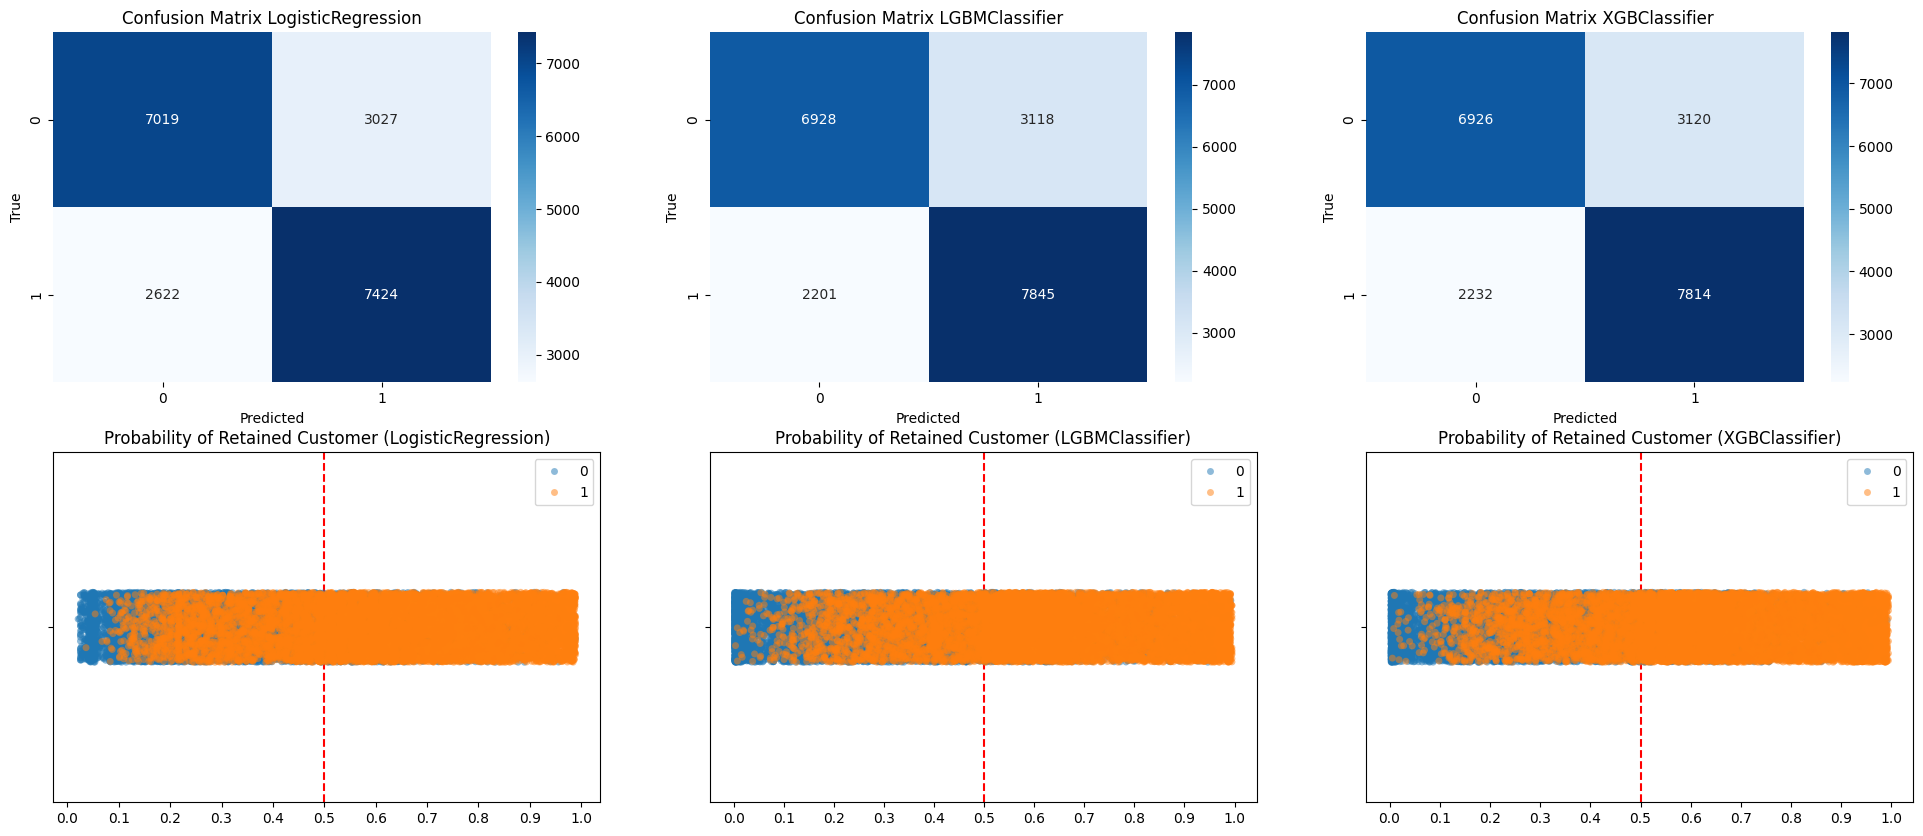

In [ ]:
i=0
threshold=0.5
fig, ax = plt.subplots(ncols=len(prediction_outputs), nrows=2, figsize=(len(prediction_outputs)*8, 10))
for model_name, y_pred_proba in prediction_outputs.items():
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)
    # Confusion Matrix plot
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0][i])
    ax[0][i].set_xlabel("Predicted")
    ax[0][i].set_ylabel("True")
    ax[0][i].set_title(f"Confusion Matrix {model_name}")

    # Stripplot plot
    sns.stripplot(x=y_pred_proba, hue=y_test.tolist(), ax=ax[1][i], alpha=0.5)
    ax[1][i].set_title(f"Probability of Retained Customer ({model_name})")
    ax[1][i].axvline(threshold, label="Threshold", color="red", linestyle="--")
    ax[1][i].set_xticks(np.arange(0, 1.001, 0.1))
    i+=1
plt.show()

Based on the confusion matrix we can see that LightGBM has the highes true positives while Logistic Regression has the highest True Negative. But the difference between True Negative is smaller, not like difference between True Positives (around 300).

## ROC AUC Curve

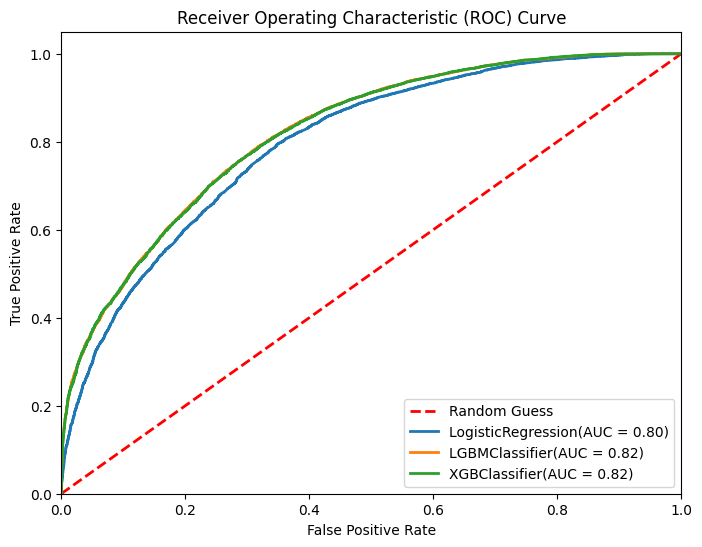

In [ ]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], color="red", linestyle="--", lw=2, label="Random Guess")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
for model_name, y_pred_proba in prediction_outputs.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # calculate TPR and FPR
    auc = roc_auc_score(y_test, y_pred_proba)  # calculate auc
    ax.plot(fpr, tpr, lw=2, label=f"{model_name}(AUC = {auc:.2f})")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic (ROC) Curve")
ax.legend(loc="lower right")

## Recall, Precision, F1, and AUC

In [ ]:
# 1. Prepare Models
recall, precision, f1, roc_auc = [], [], [], []
model_names = []
for model_name, y_pred_proba in prediction_outputs.items():
    model_names.append(model_name)
    recall.append(recall_score(y_test, np.where(y_pred_proba>0.5, 1, 0)))
    precision.append(precision_score(y_test, np.where(y_pred_proba>0.5, 1, 0)))
    f1.append(f1_score(y_test, np.where(y_pred_proba>0.5, 1, 0)))
    roc_auc.append(roc_auc_score(y_test, y_pred_proba))

# 3. Display cross validation results
pd.DataFrame(
    {
        "model": model_names,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "roc_auc": roc_auc,
    }
).sort_values(by=["roc_auc"])

model    recall  precision        f1   roc_auc
0  LogisticRegression  0.739001   0.710363  0.724399  0.796417
2       XGBClassifier  0.777822   0.714652  0.744900  0.819443
1      LGBMClassifier  0.780908   0.715589  0.746823  0.820013

Based on model comparison **LightGBM** is the best starting from recall, precisin, f1 score and auc score.

# Final Thoughts
Which metrics should we consider more, precision or recall?
1. The main objective is to find out which campaign that retained most of users. In order to do so, we want to make sure that our model able to identify retained customer accurately. Hence, we prioritize recall which  calculates percentage of actual positive class that are succesfully predicted as positive. With this we can identified the retained customer accurately.
2. If we choose to increase the recall score, there will be some down side which is an increase of false positives. But it is okay, more false positive just bring an increase to amount of predicted retained users across all campaigns.
3. Recall can be increased by reducing the threshold or focusing on increasing recall score during hyperparameter tuning.

Which is the best model?
It depends on the user requirements if:
1. they want a model that's really fast they can use Logistic Regression to compete with the performance of other models. You can do this by reducing the threshold but with the risk of increasing false positives.
2. they want the most accurate (priotizing recall) model with reasonable training and inference time, choose LightGBM.

# Suggestions
This project is far from perfect, there are some areas that needs improvement:
1. Perform feature engineerng, focusing on generating features that able to separate retain and non retained customers (since using more robust and complex model didn't increase the performance significantly)